# Data Description

## Data Source

* PUBG Match Deaths and Statistics, Kaggle 
    \- https://www.kaggle.com/skihikingkevin/pubg-match-deaths

## Data Introduction

In this Kaggle Dataset, over 720,000 competitive matches from the popular game PlayerUnknown's Battlegrounds. The data was extracted from pubg.op.gg, a game tracker website.


### PlayerUnknown's Battlegrounds

PUBG is a first/third-person shooter battle royale style game that matches over 90 players on a large island where teams and players fight to the death until one remains. Players are airdropped from an airplane onto the island where they are to scavenge towns and buildings for weapons, ammo, armor and first-aid. Players will then decide to either fight or hide with the ultimate goal of being the last one standing. A bluezone (see below) will appear a few minutes into the game to corral players closer and closer together by dealing damage to anyone that stands within the bluezone and sparing whoever is within the safe zone.


### The Dataset

This dataset provides two zips: aggregate and deaths.

In **deaths**, the files record every death that occurred within the 720k matches. That is, each row documents an event where a player has died in the match.

In **aggregate**, each match's meta information and player statistics are summarized (as provided by pubg). It includes various aggregate statistics such as player kills, damage, distance walked, etc as well as metadata on the match itself such as queue size, fpp/tpp, date, etc.
The uncompressed data is divided into 5 chunks of approximately 2gb each.

### Columns in deaths

1. killed_by: Which weapon is killed
1. killer_name: Killer game id
1. killer_placement: The final ranking of the team where the killer is located
1. killer_position_x: X coordinate of the killer when the killing behavior occurs
1. killer_position_y: Y coordinate of the killer when the killing behavior occurs
1. map: Game Map(Erangel island/ Miramar desert)
1. match_id : Event Unique ID
1. time: When the kill occurs(How many seconds after the game starts)
1. victim_name: The killed game id
1. victim_position_x: X coordinate of the person being killed when the killing occurs
1. victim_position_y: Y coordinate of the killer at the time of the killing behavior

### Columns in aggregate

1. date: Start time of the game
1. game_size: Site size
1. match_id: Event Unique ID
1. match_mode: Game Mode(First/ Third Person View)
1. party_size: Squad size(1person/ 2people/ 4people)
1. player_assists: Rescue teammates
1. player_dbno: Number of times the player was knocked down
1. player_dist_ride: Driving Distance
1. player_dist_walk: Walking distance
1. player_dmg: Injury points
1. player_kills: kills
1. player_name: Player Game id
1. player_survive_time: Player survival time
1. team_id: The player's team number
1. team_placement: The final ranking of the player's team

# 라이브러리 및 데이터 로드

## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.auto import tqdm
tqdm.pandas()
import os

In [2]:
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 데이터

In [4]:
data_dir = '../dataset/raw/'

In [6]:
def data_load(data_dir, name_list, df_list):
    df_list = []
    for i in tqdm(name_list):
        df_list.append(pd.read_csv(data_dir + i))
    return df_list

In [6]:
agg_data_dir = '../dataset/raw/aggregate/'
agg_name_list = sorted(os.listdir(agg_data_dir))
agg_list = data_load(agg_data_dir, agg_name_list, agg_list)

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
deaths_data_dir = '../dataset/raw/deaths/'
deaths_name_list = sorted(os.listdir(deaths_data_dir))
deaths_list = data_load(deaths_data_dir, deaths_name_list, deaths_list)

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
def get_shape(df_list):
    for i in df_list:
        print(i.shape)

In [10]:
get_shape(agg_list)

(13849287, 15)
(13844275, 15)
(13841504, 15)
(13840680, 15)
(11993485, 15)


In [11]:
get_shape(deaths_list)

(13426348, 12)
(13440889, 12)
(13431052, 12)
(13431331, 12)
(11640855, 12)


# Data preprocessing

## Aggregate의 na 제거

In [12]:
def df_drop_na(df_list):
    for i in tqdm(range(len(df_list))):
        df_list[i] = df_list[i].dropna()

In [13]:
df_drop_na(agg_list)

  0%|          | 0/5 [00:00<?, ?it/s]

## match_mode 제거
* 모두 'tpp'만 가짐

In [14]:
def del_col(df_list, col_name):
    for i in tqdm(df_list):
        del i[col_name]

In [15]:
del_col(agg_list, 'match_mode')

  0%|          | 0/5 [00:00<?, ?it/s]

## 두 데이터에서 매칭되지 않는 match_id 제거

In [16]:
def get_unique_match_id(df_list):
    match_id = []
    for i in df_list:
        match_id += [x for x in i['match_id'].unique()]
    return match_id

In [17]:
agg_match_id = get_unique_match_id(agg_list)

In [18]:
len(agg_match_id)

729969

In [19]:
deaths_match_id = get_unique_match_id(deaths_list)

In [20]:
agg_mat = set(agg_match_id)
deaths_mat = set(deaths_match_id)

In [21]:
len(agg_mat), len(deaths_mat), len(agg_mat & deaths_mat)

(729969, 722425, 722396)

In [22]:
get_shape(deaths_list)

(13426348, 12)
(13440889, 12)
(13431052, 12)
(13431331, 12)
(11640855, 12)


In [23]:
for i in range(len(deaths_list)):
    deaths_list[i] = deaths_list[i][deaths_list[i]['match_id'].isin(agg_match_id)]

In [24]:
get_shape(deaths_list)

(13425912, 12)
(13440074, 12)
(13430252, 12)
(13430868, 12)
(11640760, 12)


## deaths data na 처리

### map na 처리

In [25]:
deaths_list[0]['map'].unique()

array(['MIRAMAR', 'ERANGEL', nan], dtype=object)

* map 결측값 대체 가능 여부 확인

In [26]:
map_na_match_id = []
for i in deaths_list:
    map_na_match_id += [x for x in i.loc[i['map'].isnull(), 'match_id'].unique()]

In [27]:
E_match_id = []
for i in deaths_list:
    E_match_id += [x for x in i.loc[i['map'] == 'ERANGEL', 'match_id'].unique()]

In [28]:
M_match_id = []
for i in deaths_list:
    M_match_id += [x for x in i.loc[i['map'] == 'MIRAMAR', 'match_id'].unique()]

* 겹치는 match_id 확인

In [29]:
map_na_match_id = set(map_na_match_id)
E_match_id = set(E_match_id)
M_match_id = set(M_match_id)

In [30]:
len(map_na_match_id & E_match_id), len(map_na_match_id & M_match_id), len(E_match_id & M_match_id) 

(0, 0, 0)

* 대체 불가능 판단 -> Drop

In [31]:
get_shape(deaths_list)

(13425912, 12)
(13440074, 12)
(13430252, 12)
(13430868, 12)
(11640760, 12)


### deaths 데이터 na drop

In [32]:
df_drop_na(deaths_list)

  0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
get_shape(deaths_list)

(12100006, 12)
(12116443, 12)
(12108530, 12)
(12101869, 12)
(10494810, 12)


## Data 병합

* key columns
    * agg.match_id = deaths.match_id
    * agg.player_name = deaths.killer_name

In [34]:
# key column의 이름을 맞춰야 함
# deaths의 killer_name을 player_name으로 변경

def chg_col_names(df_list, col_names):
    for i in tqdm(df_list):
        i.columns = col_names

In [35]:
deaths_list[0].columns

Index(['killed_by', 'killer_name', 'killer_placement', 'killer_position_x',
       'killer_position_y', 'map', 'match_id', 'time', 'victim_name',
       'victim_placement', 'victim_position_x', 'victim_position_y'],
      dtype='object')

In [36]:
deaths_cols = ['killed_by', 'player_name', 'killer_placement', 'killer_position_x',
               'killer_position_y', 'map', 'match_id', 'time', 'victim_name',
               'victim_placement', 'victim_position_x', 'victim_position_y']

In [37]:
# key column 이름 맞추기

chg_col_names(deaths_list, deaths_cols)

  0%|          | 0/5 [00:00<?, ?it/s]

## Aggregate 데이터와 Deaths 데이터 Merge

* 같은 번호의 데이터와 짝을 이루는 것을 match_id로 확인함
    * e.g. agg_0는 deaths_0과 Merge

In [38]:
get_shape(agg_list)

(13829038, 14)
(13824209, 14)
(13821505, 14)
(13820791, 14)
(11976035, 14)


In [39]:
get_shape(deaths_list)

(12100006, 12)
(12116443, 12)
(12108530, 12)
(12101869, 12)
(10494810, 12)


In [40]:
deaths_list[0]['map'].unique()

array(['MIRAMAR', 'ERANGEL'], dtype=object)

In [41]:
def get_merged_df(left, right, join, keys):
    df_list = []
    for i in tqdm(range(len(left))):
        df_list.append(pd.merge(left[i], right[i], how=join, on=keys))
    return df_list

In [42]:
df_merge = get_merged_df(agg_list, deaths_list, 'left', ['match_id', 'player_name'])

  0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
get_shape(df_merge)

(20122234, 24)
(20125055, 24)
(20116444, 24)
(20111666, 24)
(17431740, 24)


## map 채우기

In [44]:
def fill_map_na(df_list, match_id_list, map_name):
    for i in df_list:
        i.loc[(i['match_id'].isin(match_id_list))&(i['map'].isnull()), 'map'] = map_name
    return df_list

In [45]:
match_id = [E_match_id, M_match_id]
map_names = ['ERANGEL', 'MIRAMAR']

for i in tqdm(range(len(match_id))):
    df_merge = fill_map_na(df_merge, match_id[i], map_names[i])

  0%|          | 0/2 [00:00<?, ?it/s]

## map별로 데이터 나누기

* ERANGEL과 MIRAMAR로 데이터 셋을 나눔

In [46]:
def get_df_map(df_list, map_name):
    df_map = []
    for i in df_list:
        df_map.append(i[i['map'] == map_name])
    return df_map

In [47]:
df_map  = []
for i in tqdm(range(len(map_names))):
    df_map.append(get_df_map(df_merge, map_names[i]))

  0%|          | 0/2 [00:00<?, ?it/s]

## party_size 별로 데이터 나누기

* party_size에 따라 Tier가 다르기 때문에 데이터를 분리함

In [48]:
def get_df_party_size(df_list, party_size):
    df_party_size = []
    for i in df_list:
        df_party_size.append(i[i['party_size'] == party_size])
    return df_party_size

In [50]:
df = []
party_size = [1, 2, 4]

for i in tqdm(range(len(party_size))):
    for j in range(len(df_map)):
        df.append(get_df_party_size(df_map[j], party_size[i]))

  0%|          | 0/3 [00:00<?, ?it/s]

In [51]:
# df[0]: solo, ERANGEL / df[1]: solo, MIRAMAR
# df[2]: duo, ERANGEL / df[3]: duo, MIRAMAR
# df[4]: squad, ERANGEL / df[5]: squad, MIRAMAR

len(df)

6

## party_size별 map별 dataset 합치기

In [52]:
def get_concat(df_list):
    df_concat = []
    for i in tqdm(range(len(df_list))):
        df_concat.append(pd.concat(df_list[i], ignore_index=True))
    return df_concat

In [53]:
# df_concat[0]: solo, ERANGEL / df_concat[1]: solo, MIRAMAR
# df_concat[2]: duo, ERANGEL / df_concat[3]: duo, MIRAMAR
# df_concat[4]: squad, ERANGEL / df_concat[5]: squad, MIRAMAR

df_concat = get_concat(df)

  0%|          | 0/6 [00:00<?, ?it/s]

## killed_by 그룹핑

In [54]:
def killed_by_refine(df):
    df['killed_by'] = df['killed_by'].replace({'death.WeapSawnoff_C': 'sawed_off', 
                                               'death.PlayerMale_A_C': 'Punch',
                                               'death.PG117_A_01_C': 'Boat' , 'death.RedZoneBomb_C': 'RedZone'})
    df['killed_by'] = df['killed_by'].replace(['Pickup Truck','Hit by Car','Buggy','Dacia','Motorbike',
                                               'Motorbike (SideCar)','Uaz','Van'], 'land_vehicle')
    df['killed_by'] = df['killed_by'].replace(['death.ProjMolotov_C', 'death.ProjMolotov_DamageField_C', 
                                               'death.Buff_FireDOT_C'], 'Molotov')
    df['killed_by'] = df['killed_by'].replace(['Aquarail','Boat'], 'water_vehicle')

In [55]:
for i in tqdm(df_concat):
    killed_by_refine(i)

  0%|          | 0/6 [00:00<?, ?it/s]

## csv로 내보내기

In [56]:
def df_read_csv(df_list, data_dir, file_name):
    for i in tqdm(range(len(df_list))):
        df_list[i].to_csv(data_dir + f'{file_name[i]}.csv', index=False)

In [57]:
data_dir = '../dataset/preprocessing/'
file_name = ['solo_E', 'solo_M', 'duo_E', 'duo_M', 'squad_E', 'squad_M']

df_read_csv(df_concat, data_dir, file_name)

  0%|          | 0/6 [00:00<?, ?it/s]

# Outlier 처리

In [7]:
data_dir = '../dataset/preprocessing/'
name_list = ['solo_E.csv', 'solo_M.csv', 'duo_E.csv', 'duo_M.csv', 'squad_E.csv', 'squad_M.csv']
df_prep = []

df_prep = data_load(data_dir, name_list, df_prep)

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
# df_prep[0]: solo, ERANGEL / df_prep[1]: solo, MIRAMAR
# df_prep[2]: duo, ERANGEL / df_prep[3]: duo, MIRAMAR
# df_prep[4]: squad, ERANGEL / df_prep[5]: squad, MIRAMAR

get_shape(df_prep)

(17105104, 24)
(3096664, 24)
(25881722, 24)
(5208521, 24)
(36231117, 24)
(8886496, 24)


In [57]:
df_prep = df_prep_raw.copy()

##  Outlier 처리

In [44]:
class CheckingOutlier:
    
    '''
    Outlier 처리를 위한 Class 입니다.
    아래의 기준에 만족하는 데이터만 사용합니다.
    
    game_size : solo  - 80 이상
                duo   - 40 이상
                squad - 20 이상
    dist_ride : 30000(30km) 이하
    dist_walk : 10000(10km) 이하
    kills :     30 kill 이하
    dmg :       3000 damage 이하
    kill_dist : 40000(400m) 이하
    dbno :      duo/squad : 11 이하
    survive_time : 1900 이하
    
    '''
    
    def game_size(self, df):
        if df['party_size'].unique() == 1:
            df = df.loc[df['game_size'] >= 80]
        elif df['party_size'].unique() == 2:
            df = df.loc[df['game_size'] >= 40]
        else:
            df = df.loc[df['game_size'] >= 20]
        return df
        
    def player_dist_ride(self, df):
        df = df.loc[df['player_dist_ride'] <= 30000]
        return df
    
    def player_dist_walk(self, df):
        df = df.loc[df['player_dist_walk'] <= 10000]
        return df
        
    def player_kills(self, df):
        df = df.drop(df.loc[df['player_kills'] > 30].index)
        return df
    
    def player_dmg(self, df):
        df = df.drop(df.loc[df['player_dmg'] > 3000].index)  
        return df
        
    def kill_dist(self, df):
        df['kill_dist'] = np.sqrt(((df['killer_position_x'] - df['victim_position_x']) ** 2) 
                                      + ((df['killer_position_y'] - df['victim_position_y']) ** 2))
        df = df.drop(df.loc[df['kill_dist'] > 4000].index)
        return df    
    
    def player_dbno(self, df):
        if df['party_size'].unique() != 1 :
            df = df.drop(df.loc[df['player_dbno'] > 11].index)
        else:
            del df['player_dbno']
        return df
    
    def player_survive_time(self, df):
        df = df.drop(df.loc[df['player_survive_time'] > 1900].index)
        return df


In [61]:
def check_outlier(df_list):
    new_df_list = []
    checker = CheckingOutlier()
    
    for df in tqdm(df_list):
        filtered_df = pd.DataFrame()
        filtered_df = checker.game_size(df)
        filtered_df = checker.player_dist_ride(filtered_df)
        filtered_df = checker.player_dist_walk(filtered_df)
        filtered_df = checker.player_kills(filtered_df)
        filtered_df = checker.player_dmg(filtered_df)
        filtered_df = checker.kill_dist(filtered_df)
        filtered_df = checker.player_dbno(filtered_df)
        filtered_df = checker.player_survive_time(filtered_df)
        new_df_list.append(filtered_df)
            
    return new_df_list

In [62]:
df_outlier = check_outlier(df_prep)

  0%|          | 0/6 [00:00<?, ?it/s]

In [64]:
len(df_outlier)

6

## 분석 Dataset 확인

In [72]:
get_shape(df_outlier)

(13064334, 24)
(2356444, 24)
(19760294, 25)
(4066757, 25)
(27687839, 25)
(7104464, 25)


In [65]:
df_outlier[0].describe()

,game_size,party_size,player_assists,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,13064334.000,13064334.000,13064334.000,13064334.000,13064334.000,13064334.000,13064334.000,13064334.000,13064334.000,13064334.000,6816921.000,6816921.000,6816921.000,6816921.000,6816921.000,6816921.000,6816921.000,6816921.000
mean,94.116,1.000,0.070,1019.454,1215.797,168.559,1.472,786.599,100048.668,45.289,31.839,421255.396,402837.169,525.082,57.335,421253.954,402834.564,1130.400
std,3.846,0.000,0.272,1778.592,1194.654,223.891,2.209,569.017,28.679,27.968,23.340,133201.180,133911.720,468.256,25.023,133203.022,133911.283,1006.996
min,80.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,100000.000,1.000,1.000,0.000,0.000,54.000,1.000,0.000,0.000,0.000
25%,93.000,1.000,0.000,0.000,189.917,0.000,0.000,239.214,100024.000,20.000,11.000,348617.600,317868.000,158.000,39.000,348665.800,317852.700,366.860
50%,95.000,1.000,0.000,0.000,852.513,100.000,1.000,686.399,100049.000,45.000,27.000,422090.700,388368.900,318.000,61.000,422055.500,388299.500,756.262
75%,97.000,1.000,0.000,1538.276,1965.691,245.000,2.000,1303.868,100073.000,69.000,49.000,516034.300,481652.300,787.000,78.000,516055.300,481668.600,1667.047
max,100.000,1.000,6.000,26844.410,9999.756,2999.000,30.000,1899.997,100121.000,100.000,100.000,810680.300,795355.900,2043.000,100.000,810731.300,795355.900,3999.997


In [67]:
df_outlier[1].describe()

,game_size,party_size,player_assists,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,2356444.000,2356444.000,2356444.000,2356444.000,2356444.000,2356444.000,2356444.000,2356444.000,2356444.000,2356444.000,1233818.000,1233818.000,1233818.000,1233818.000,1233818.000,1233818.000,1233818.000,1233818.000
mean,88.889,1.000,0.074,804.412,1297.598,169.284,1.474,771.003,100048.949,43.090,30.630,401376.793,384552.595,514.149,53.969,401375.064,384559.649,1236.500
std,4.039,0.000,0.278,1541.409,1294.388,213.731,2.107,571.599,28.640,26.657,22.563,117650.294,121115.148,472.579,23.884,117648.078,121117.190,1028.376
min,80.000,1.000,0.000,0.000,0.000,0.000,0.000,7.035,100000.000,1.000,1.000,15872.990,6278.910,52.000,2.000,15577.670,6278.910,0.000
25%,86.000,1.000,0.000,0.000,177.860,0.000,0.000,221.135,100024.000,19.000,11.000,343782.650,286082.850,148.000,36.000,343766.175,286078.500,424.024
50%,89.000,1.000,0.000,0.000,860.786,100.000,1.000,659.400,100049.000,43.000,26.000,384097.300,389148.300,301.000,57.000,384114.450,389114.350,907.311
75%,92.000,1.000,0.000,1031.810,2157.820,251.000,2.000,1291.803,100074.000,66.000,48.000,465796.450,444448.100,766.000,74.000,465806.150,444433.675,1850.692
max,100.000,1.000,4.000,29583.578,9980.483,2987.000,30.000,1899.998,100123.000,100.000,97.000,813956.900,794637.700,2175.000,100.000,813956.900,794637.700,3999.999


In [68]:
df_outlier[2].describe()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,19760294.000,19760294.000,19760294.000,19760294.000,19760294.000,19760294.000,19760294.000,19760294.000,19760294.000,19760294.000,19760294.000,10004222.000,10004222.000,10004222.000,10004222.000,10004222.000,10004222.000,10004222.000,10004222.000
mean,48.452,2.000,0.250,0.883,1221.850,1258.657,180.289,1.491,804.419,25.715,24.206,18.957,423697.783,400156.509,543.952,29.926,423695.680,400155.168,1151.992
std,1.854,0.000,0.586,1.242,1895.407,1189.711,226.685,2.186,571.630,14.508,14.175,13.199,142085.966,138564.721,472.386,12.924,142088.250,138563.818,1042.606
min,40.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,-19185.750,0.000,56.000,1.000,-19152.120,0.000,0.000
25%,48.000,2.000,0.000,0.000,0.000,230.965,14.000,0.000,260.912,13.000,12.000,7.000,348601.650,304359.800,177.000,20.000,348622.125,304359.925,333.482
50%,49.000,2.000,0.000,0.000,0.000,903.767,100.000,1.000,693.716,26.000,24.000,17.000,422806.800,384142.400,337.000,32.000,422709.600,384041.800,752.315
75%,50.000,2.000,0.000,1.000,2099.267,2037.672,260.000,2.000,1324.471,38.000,36.000,30.000,539791.300,485145.600,809.000,41.000,539824.375,485132.975,1759.590
max,51.000,2.000,12.000,11.000,29835.404,9999.921,2922.000,29.000,1900.000,258.000,51.000,51.000,810635.500,795290.900,2139.000,51.000,810741.600,795290.900,3999.999


In [69]:
df_outlier[3].describe()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,4066757.000,4066757.000,4066757.000,4066757.000,4066757.000,4066757.000,4066757.000,4066757.000,4066757.000,4066757.000,4066757.000,2081664.000,2081664.000,2081664.000,2081664.000,2081664.000,2081664.000,2081664.000,2081664.000
mean,45.414,2.000,0.247,0.894,987.665,1353.922,181.801,1.511,793.225,25.317,22.735,18.038,401761.204,380340.525,539.164,27.912,401762.703,380346.470,1223.351
std,2.310,0.000,0.579,1.224,1696.821,1295.004,219.995,2.143,573.342,14.337,13.399,12.564,124150.978,127112.833,476.716,12.224,124149.326,127115.811,1054.400
min,40.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,34.979,1.000,1.000,1.000,0.000,0.000,56.000,1.000,0.000,0.000,0.000
25%,44.000,2.000,0.000,0.000,0.000,227.048,18.000,0.000,249.084,13.000,11.000,7.000,346221.100,281412.900,168.000,19.000,346241.700,281415.700,367.871
50%,46.000,2.000,0.000,1.000,0.000,932.508,100.000,1.000,676.943,25.000,23.000,16.000,382101.250,385553.000,330.000,30.000,382084.550,385558.400,863.798
75%,47.000,2.000,0.000,1.000,1533.081,2256.299,266.000,2.000,1318.975,38.000,34.000,28.000,455741.675,441647.250,795.000,38.000,455718.425,441685.975,1880.704
max,50.000,2.000,10.000,11.000,27013.408,9911.751,2636.000,26.000,1899.991,51.000,50.000,50.000,814274.400,815168.200,1961.000,50.000,814274.400,815209.600,3999.991


In [70]:
df_outlier[4].describe()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,27687839.000,27687839.000,27687839.000,27687839.000,27687839.000,27687839.000,27687839.000,27687839.000,27687839.000,27687839.000,27687839.000,13466920.000,13466920.000,13466920.000,13466920.000,13466920.000,13466920.000,13466920.000,13466920.000
mean,27.066,4.000,0.342,1.247,1329.095,1351.619,176.914,1.411,843.250,14.328,13.973,12.141,417741.703,399894.591,582.108,16.940,417738.598,399894.338,1104.624
std,1.562,0.000,0.714,1.712,1974.750,1227.496,219.382,2.092,574.465,8.053,7.856,7.805,146008.373,143219.329,482.345,7.329,146010.739,143216.573,1050.494
min,20.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,-71095.730,-70411.010,23.000,1.000,-71107.960,-70481.330,0.000
25%,26.000,4.000,0.000,0.000,0.000,283.119,14.000,0.000,298.444,7.000,7.000,5.000,346324.800,292522.175,204.000,11.000,346380.100,292542.700,291.977
50%,27.000,4.000,0.000,1.000,0.000,1006.461,100.000,0.000,745.300,14.000,14.000,11.000,420921.400,387896.200,379.000,18.000,420914.300,387844.800,667.888
75%,28.000,4.000,0.000,2.000,2343.366,2190.821,256.000,2.000,1379.001,21.000,21.000,19.000,535474.925,492139.825,869.000,23.000,535463.825,492120.200,1699.005
max,35.000,4.000,13.000,11.000,29940.578,9994.319,2913.000,23.000,1900.000,58.000,35.000,35.000,810724.700,795259.900,2182.000,35.000,810775.600,795266.100,3999.999


In [71]:
df_outlier[5].describe()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,7104464.000,7104464.000,7104464.000,7104464.000,7104464.000,7104464.000,7104464.000,7104464.000,7104464.000,7104464.000,7104464.000,3541920.000,3541920.000,3541920.000,3541920.000,3541920.000,3541920.000,3541920.000,3541920.000
mean,26.325,4.000,0.340,1.275,1032.770,1441.187,179.915,1.455,825.135,14.329,13.508,11.779,399600.388,378193.589,571.514,16.337,399600.527,378197.128,1149.280
std,1.844,0.000,0.701,1.693,1731.200,1329.633,214.700,2.083,574.779,8.092,7.714,7.622,129842.098,130364.678,482.741,7.190,129840.564,130367.462,1053.250
min,20.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,55.000,1.000,0.000,0.000,0.000
25%,25.000,4.000,0.000,0.000,0.000,280.994,19.000,0.000,282.590,7.000,7.000,5.000,349550.575,281329.500,191.000,11.000,349551.175,281324.500,313.946
50%,26.000,4.000,0.000,1.000,0.000,1027.241,100.000,0.000,713.811,14.000,13.000,11.000,377876.500,399845.100,372.000,17.000,377894.600,399831.150,744.014
75%,28.000,4.000,0.000,2.000,1645.423,2395.001,263.000,2.000,1359.871,21.000,20.000,18.000,457165.200,442692.950,840.000,22.000,457173.950,442695.650,1771.760
max,36.000,4.000,10.000,11.000,29290.750,9984.742,2345.000,21.000,1900.000,37.000,36.000,36.000,805065.800,815183.800,2025.000,36.000,805171.500,815183.800,3999.995


## Dataset 분리하기

* Outlier를 제거한 데이터셋과 Outlier만 모은 데이터셋으로 분리

In [103]:
def seperating_dataset(df_raw_list, df_in_list):
    df_in = []
    df_out = []
    
    for i in tqdm(range(len(df_in_list))):
        in_idx = []
        in_idx = list(df_in_list[i].index)
        max_idx = max(df_in_list[i].index)
        out_idx = []
        out_idx = list(set(list(range(max_idx))) - set(in_idx))
        df_in.append(df_in_list[i].reset_index(drop=True))
        df_out.append(df_raw_list[i].loc[out_idx].reset_index(drop=True))
    return df_in, df_out

In [104]:
df_in, df_out = seperating_dataset(df_prep, df_outlier)

  0%|          | 0/6 [00:00<?, ?it/s]

In [105]:
get_shape(df_in)

(13064334, 24)
(2356444, 24)
(19760294, 25)
(4066757, 25)
(27687839, 25)
(7104464, 25)


In [106]:
get_shape(df_out)

(4040770, 24)
(740217, 24)
(6121428, 24)
(1141764, 24)
(8543278, 24)
(1782032, 24)


## csv로 내보내기

In [107]:
def df_read_csv(df_list, data_dir, file_name):
    for i in tqdm(range(len(df_list))):
        df_list[i].to_csv(data_dir + f'{file_name[i]}.csv', index=False)

In [109]:
data_dir = '../dataset/outlier/'
in_file_name = ['solo_E_in', 'solo_M_in', 'duo_E_in', 'duo_M_in', 'squad_E_in', 'squad_M_in']
out_file_name = ['solo_E_out', 'solo_M_out', 'duo_E_out', 'duo_M_out', 'squad_E_out', 'squad_M_out']

df_read_csv(df_in, data_dir, in_file_name)
df_read_csv(df_out, data_dir, out_file_name)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# play_count 10회 이상인 player 선택
* 분석을 위해 play 횟수가 10회 이상인 player만 선택

In [130]:
data_dir = '../dataset/outlier/'
in_file_list = list(map(lambda x: x + '.csv', in_file_name))

In [131]:
df_outlier  = data_load(data_dir, in_file_list, df)

  0%|          | 0/6 [00:00<?, ?it/s]

In [149]:
# party_size별로 데이터 concat으로 합치기

df_concat = []
for i in tqdm(range(len(df_outlier))):
    if i % 2 == 1:
        continue
    df_concat.append(pd.concat([df_outlier[i], df_outlier[i+1]], ignore_index=True))

  0%|          | 0/6 [00:00<?, ?it/s]

In [160]:
def get_df_play_count(df_list):
    df_play_count = []
    for df in tqdm(df_list):
        play_count = []
        play_count = df.groupby('player_name')['match_id'].nunique().to_frame()
        play_count_idx = play_count.loc[play_count['match_id'] >= 10].index
        df_play_count.append(df.loc[df['player_name'].isin(play_count_idx)])
    return df_play_count

In [161]:
df_play_count = get_df_play_type(df_concat)

  0%|          | 0/3 [00:00<?, ?it/s]

In [164]:
data_dir = '../dataset/play_count/'
file_name = ['solo', 'duo', 'squad']

df_read_csv(df_play_count, data_dir, file_name)

  0%|          | 0/3 [00:00<?, ?it/s]

# 파생변수 생성

In [ ]:
df = pd.read_csv('../dataset/duo/duo.csv')

In [ ]:
df.shape

In [ ]:
df.info()

### date

* 날짜형 데이터 처리

In [ ]:
df['date'] = pd.to_datetime(df['date'])

### Score
* each_game_score: (50 - team_placement) * 1 + player_kills * 2 + player_assists * 2
* total_score: sum(each_game_score) by player_name

In [ ]:
df['team_placement'].value_counts()

In [ ]:
# player별 각 게임에서의 점수 계산

df['each_game_score'] = (50 - df['team_placement'])*1 + df['player_kills']*2 + df['player_assists']*2
min(df['each_game_score']), max(df['each_game_score'])

In [ ]:
# player별 총 점수를 계산

score = df.groupby(['player_name', 'match_id'])['each_game_score'].mean().to_frame()
total_score = score.groupby('player_name')['each_game_score'].sum().to_frame()
total_score.columns = ['total_score']
min(total_score['total_score']), max(total_score['total_score'])

In [ ]:
total_score['total_score'].hist(bins=1000)
plt.ticklabel_format(style='plain')

In [ ]:
total_score.loc[total_score['total_score'] > 1500, 'total_score'].count()

In [ ]:
df['total_score'] = total_score.loc[df['player_name'], 'total_score'].values

In [ ]:
df['total_score'] = np.log(df['total_score'])

In [ ]:
df.groupby('player_name')['total_score'].mean().hist(bins=1000)

### Tier

In [ ]:
def get_tier(score):
    if score < 6:
        return 1 # Bronze
    elif score < 6.75:
        return 2 # Silver
    elif score < 7.5:
        return 3 # Gold
    elif score < 8.25:
        return 4 # Platinum
    elif score < 9:
        return 5 # Diamond
    else: 
        return 6 # Master

In [ ]:
df['tier'] = df['total_score'].apply(lambda x: get_tier(x))

In [ ]:
df.groupby('player_name')['tier'].mean().hist()

In [ ]:
df.groupby('tier')['player_name'].nunique()

In [ ]:
df.groupby('tier')['player_name'].nunique()/491883*100

### KDA
* (kills + assists)/deaths

#### kills

In [ ]:
kill = df.groupby(['player_name', 'match_id'])['player_kills'].mean().to_frame()

In [ ]:
kills = kill.groupby('player_name')['player_kills'].sum().to_frame()

In [ ]:
kills.head()

In [ ]:
kills.isnull().sum()

#### assists

In [ ]:
assist = df.groupby(['player_name', 'match_id'])['player_assists'].mean().to_frame()

In [ ]:
assists = assist.groupby('player_name')['player_assists'].sum().to_frame()

In [ ]:
assists.head()

In [ ]:
assists.isnull().sum()

#### deaths

In [ ]:
# 1등 한 game 횟수
count_rank1 = df[df['team_placement']==1].groupby('player_name')['match_id'].nunique().to_frame()
count_rank1.columns = ['rank1']

In [ ]:
count_rank1.isnull().sum()

In [ ]:
# play한 game 횟수

game_count = df.groupby('player_name')['match_id'].nunique().to_frame()
game_count.columns = ['games']

In [ ]:
game_count.isnull().sum()

In [ ]:
deaths = pd.merge(count_rank1, game_count, how='outer', on='player_name')
deaths.head()

In [ ]:
deaths.isnull().sum()

In [ ]:
deaths = deaths.fillna(0)

In [ ]:
deaths['deaths'] = deaths['games'] - deaths['rank1']
deaths.head(1)

#### KDA

In [ ]:
kda = pd.merge(kills, assists, how='outer', on='player_name')
kda = pd.merge(kda, deaths['deaths'], how='outer', on='player_name')
kda.isnull().sum()

In [ ]:
kda['kda'] = (kda['player_kills'] + kda['player_assists']) / kda['deaths']
kda.head()

In [ ]:
df = pd.merge(df, kda['kda'], how='left', on='player_name')

In [ ]:
df['kda'].isnull().sum()

### num_of_match
* player별 play 횟수

In [ ]:
# tier별 차이를 확인하는 데에 필요한 컬럼만 선택

cols = ['player_name', 'match_id', 'player_kills', 'player_dmg', 'player_assists', 'player_dbno',  'kda',
        'player_dist_walk', 'player_dist_ride', 'kill_dist', 'player_survive_time', 'team_placement', 'tier']

df_player_match = pd.pivot_table(data=df[cols], index=['player_name', 'match_id'], aggfunc='mean')

In [ ]:
# player별 game play 횟수

num_of_match = df_player_match.groupby('player_name')['tier'].value_counts().to_frame()
num_of_match.columns = ['num_of_match']

In [ ]:
df_player = df_player_match.groupby('player_name').mean()
df_player = pd.merge(df_player, num_of_match, how='left', on='player_name')

In [ ]:
df_player = df_player[['player_kills', 'player_dmg', 'player_assists', 'player_dbno',  'kda', 'player_dist_walk', 
                       'player_dist_ride', 'kill_dist', 'player_survive_time', 'team_placement',
                       'num_of_match','tier']]
df_player.head()

In [ ]:
df_player.shape

In [ ]:
df_player.info()

In [ ]:
df_player.to_csv('tier_diff_duo.csv', index=False)

# Tier별 차이 검정

In [165]:
import scipy.stats as stats
import scikit_posthocs as sp

In [168]:
df = pd.read_csv('../dataset/duo/tier_diff_duo.csv')
df.shape

(491883, 12)

In [174]:
def get_tier_df(df):
    tier_df_list = []   
    for i in range(1, 7):
        tier_df_list.append(df.loc[df['tier'] == i])
    return tier_df_list

In [205]:
class TierDiffTest():
    
    def normality(self, df_list, col_name):
        normality = []
        for df in df_list:
            tier_normality = stats.anderson(df['player_kills'], dist='norm')
            normality.append((tier_normality[0] < tier_normality[1][2]))
        return normality

    def kruskal(self, df_list, col_name):
        k = stats.kruskal(df_list[0][col_name],
                          df_list[1][col_name],
                          df_list[2][col_name],
                          df_list[3][col_name],
                          df_list[4][col_name],
                          df_list[5][col_name])
        return k[1]
        
    def multiple_comparison(self, df, col_name):
        comparison = pd.DataFrame()
        comparison = sp.posthoc_conover(df, val_col = col_name, group_col = 'tier', p_adjust = 'holm')
        return comparison

## Solo

In [ ]:
solo = tier_diff[0]

In [175]:
solo_tier = get_tier_df(solo)

In [ ]:
solo.corr().style.background_gradient(cmap='Blues')

In [169]:
solo.groupby('tier').mean()

,player_kills,player_dmg,player_assists,player_dbno,kda,player_dist_walk,player_dist_ride,kill_dist,player_survive_time,team_placement,num_of_match
tier,,,,,,,,,,,
1.000,0.328,54.034,0.121,0.255,0.450,869.150,757.750,2291.038,585.483,29.700,10.995
2.000,0.740,107.030,0.200,0.503,0.954,1145.747,1092.852,2976.333,730.444,25.536,13.740
3.000,1.062,146.216,0.249,0.690,1.353,1216.736,1207.519,3283.141,772.982,24.514,23.314
4.000,1.191,161.499,0.261,0.767,1.521,1186.687,1216.130,3286.281,763.492,24.745,45.543
5.000,1.314,174.857,0.281,0.834,1.674,1163.218,1231.058,3237.264,756.397,24.882,88.560
6.000,1.389,182.751,0.293,0.875,1.786,1146.015,1214.897,3162.739,746.533,25.142,193.790


In [220]:
def checking_tier_diff(df, df_tier, check_columns):
        checker = TierDiffTest()
        normality = {}
        kruskal = {}
        comparison = {}
        
        for col in tqdm(check_columns):
            normality[col] = checker.normality(df_tier, col)
            kruskal[col] = checker.kruskal(df_tier, col)
            comparison[col] = checker.multiple_comparison(df, col).style.background_gradient(cmap='Blues')
        
        return normality, kruskal, comparison

In [221]:
check_cols = solo.groupby('tier').mean().columns

solo_n, solo_k, solo_c = checking_tier_diff(solo, solo_tier, check_cols)

  0%|          | 0/11 [00:00<?, ?it/s]

In [224]:
solo_n

{'player_kills': [False, False, False, False, False, False],
 'player_dmg': [False, False, False, False, False, False],
 'player_assists': [False, False, False, False, False, False],
 'player_dbno': [False, False, False, False, False, False],
 'kda': [False, False, False, False, False, False],
 'player_dist_walk': [False, False, False, False, False, False],
 'player_dist_ride': [False, False, False, False, False, False],
 'kill_dist': [False, False, False, False, False, False],
 'player_survive_time': [False, False, False, False, False, False],
 'team_placement': [False, False, False, False, False, False],
 'num_of_match': [False, False, False, False, False, False]}

In [225]:
solo_k

{'player_kills': 0.0,
 'player_dmg': 0.0,
 'player_assists': 0.0,
 'player_dbno': 0.0,
 'kda': 0.0,
 'player_dist_walk': 0.0,
 'player_dist_ride': 0.0,
 'kill_dist': nan,
 'player_survive_time': 0.0,
 'team_placement': 0.0,
 'num_of_match': 0.0}

### player_kills
* Tier와 평균 kill 횟수는 비례함

In [234]:
def get_tier_median(df, col):
    return df.groupby('tier')[col].median().to_frame()

In [235]:
get_tier_median(solo, 'player_kills')

,player_kills
tier,
1.000,0.300
2.000,0.667
3.000,0.923
4.000,1.021
5.000,1.142
6.000,1.250


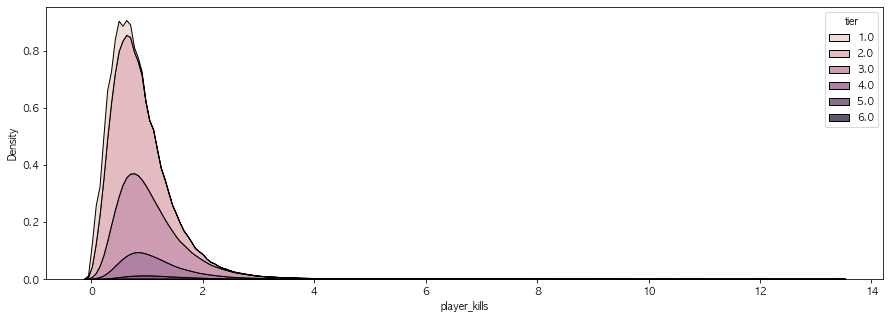

In [265]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=solo, x='player_kills', hue='tier', multiple='stack')

In [226]:
solo_c['player_kills']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.008726
6.0,0.000000,0.000000,0.000000,0.000000,0.008726,1.000000


### player_dmg

In [236]:
get_tier_median(solo, 'player_dmg')

,player_dmg
tier,
1.000,52.833
2.000,100.700
3.000,131.538
4.000,142.800
5.000,156.502
6.000,165.968


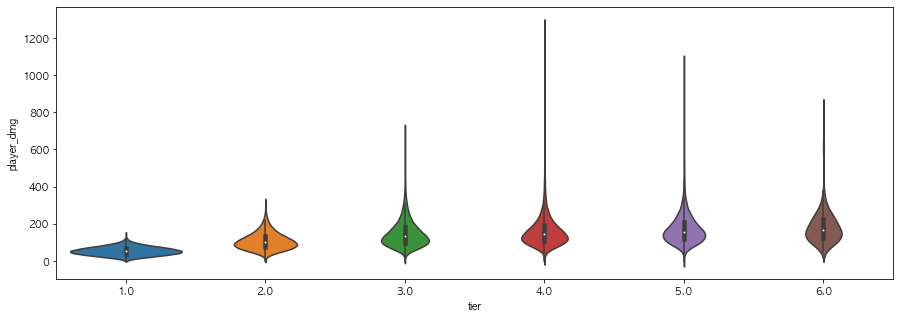

In [266]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_dmg')

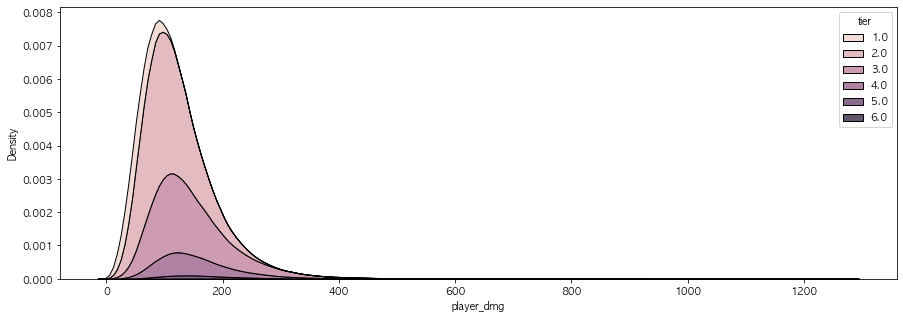

In [267]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dmg', hue='tier', multiple='stack')

In [239]:
solo_c['player_dmg']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.017837
6.0,0.000000,0.000000,0.000000,0.000000,0.017837,1.000000


### player_assists
* Tier와 평균 assits 횟수는 비례함 

In [240]:
get_tier_median(solo, 'player_assists')

,player_assists
tier,
1.000,0.100
2.000,0.176
3.000,0.217
4.000,0.233
5.000,0.255
6.000,0.264


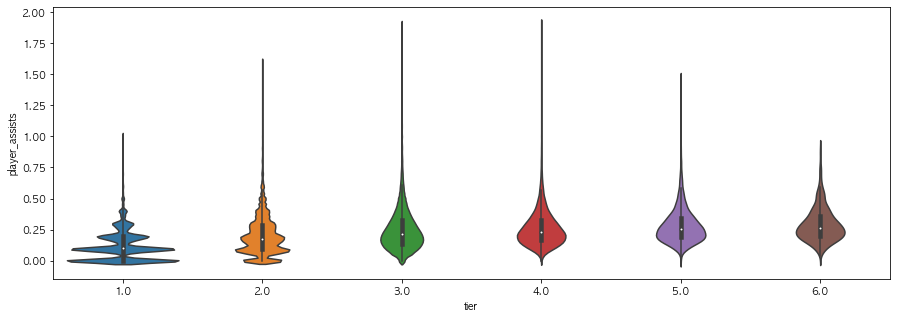

In [268]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_assists')

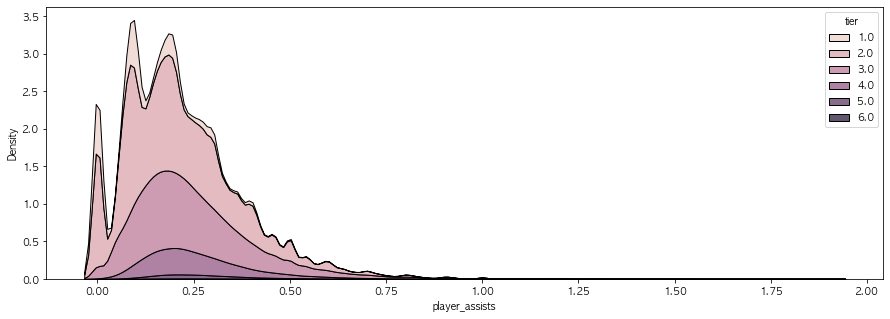

In [269]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_assists', hue='tier', multiple='stack')

In [243]:
solo_c['player_assists']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.036097
6.0,0.000000,0.000000,0.000000,0.000000,0.036097,1.000000


### player_dbno
* Tier와 평균 dbno 횟수는 비례함 

In [244]:
get_tier_median(solo, 'player_dbno')

,player_dbno
tier,
1.000,0.231
2.000,0.462
3.000,0.615
4.000,0.674
5.000,0.745
6.000,0.815


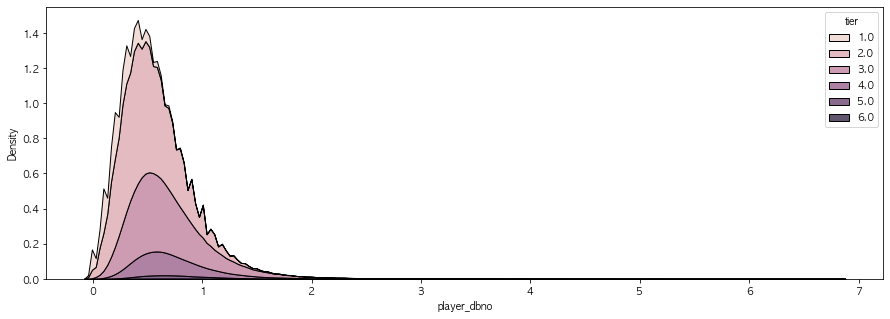

In [270]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dbno', hue='tier', multiple='stack')

In [246]:
solo_c['player_dbno']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.007047
6.0,0.000000,0.000000,0.000000,0.000000,0.007047,1.000000


### kda
* Tier와 평균 kda는 비례함

In [248]:
get_tier_median(solo, 'kda')

,kda
tier,
1.000,0.417
2.000,0.875
3.000,1.172
4.000,1.282
5.000,1.427
6.000,1.555


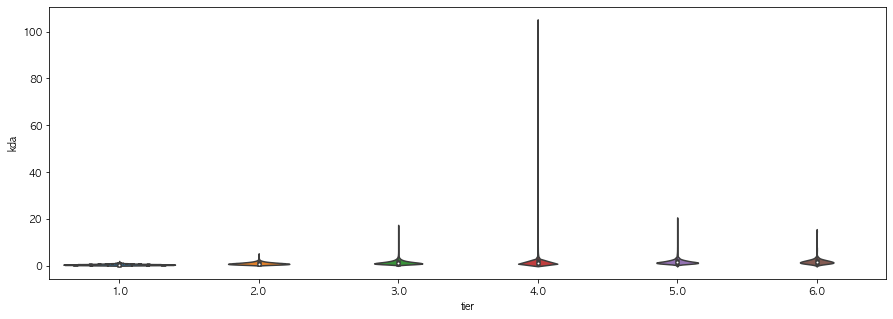

In [271]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='kda')

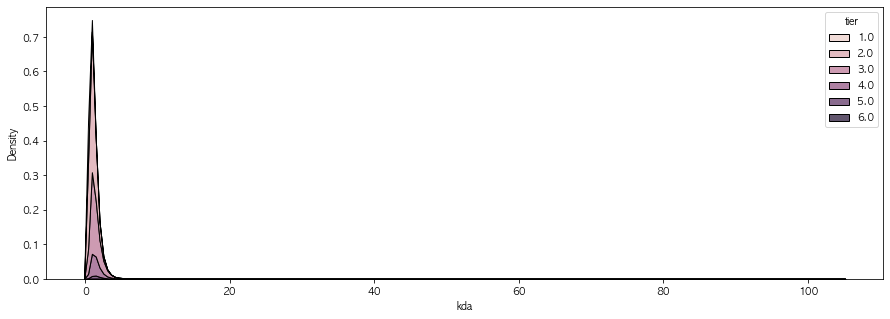

In [272]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='kda', hue='tier', multiple='stack')

In [251]:
solo_c['kda']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.013054
6.0,0.000000,0.000000,0.000000,0.000000,0.013054,1.000000


### player_dist_walk
* Tier 1~3 에서 평균 거리가 증가
* Tier 3~6 에서는 거리가 감소
* Tier 2와 5는 평균의 차이가 없음

In [252]:
get_tier_median(solo, 'player_dist_walk')

,player_dist_walk
tier,
1.000,838.463
2.000,1112.323
3.000,1180.451
4.000,1148.594
5.000,1122.241
6.000,1104.615


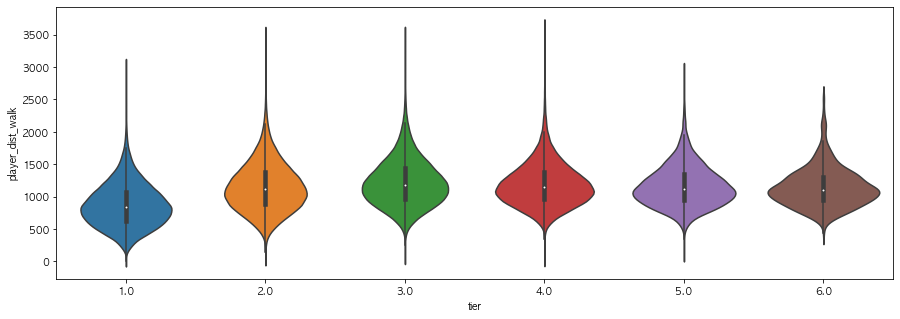

In [273]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_dist_walk')

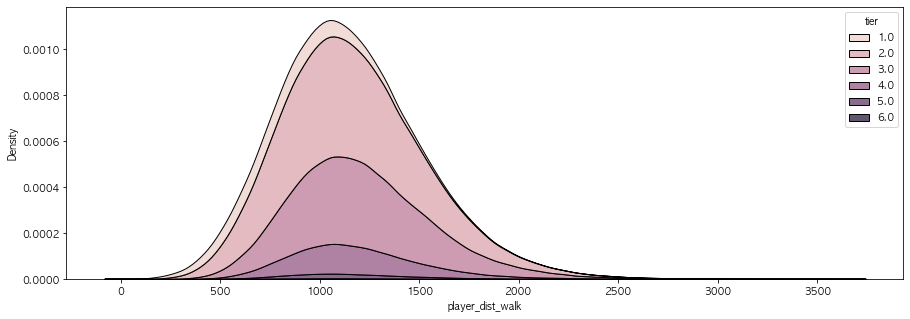

In [274]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dist_walk', hue='tier', multiple='stack')

In [255]:
solo_c['player_dist_walk']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000001,0.835714
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000003
4.0,0.000000,0.000000,0.000000,1.000000,0.000002,0.007367
5.0,0.000000,0.000001,0.000000,0.000002,1.000000,0.354439
6.0,0.000000,0.835714,0.000003,0.007367,0.354439,1.000000


### player_dist_ride
* Tier 1에서는 확실히 탈것을 활용한 이동 거리가 짧음
* Tier 2부터는 그룹간의 차이가 있긴하는하지만, tier와 탈것을 활용한 이동 거리가 정비례 하지는 않음

In [256]:
get_tier_median(solo, 'player_dist_ride')

,player_dist_ride
tier,
1.000,657.042
2.000,977.059
3.000,1087.587
4.000,1096.282
5.000,1104.539
6.000,1074.015


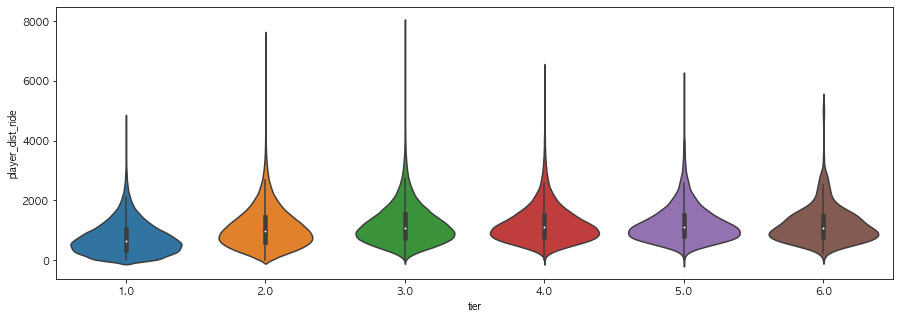

In [275]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_dist_ride')

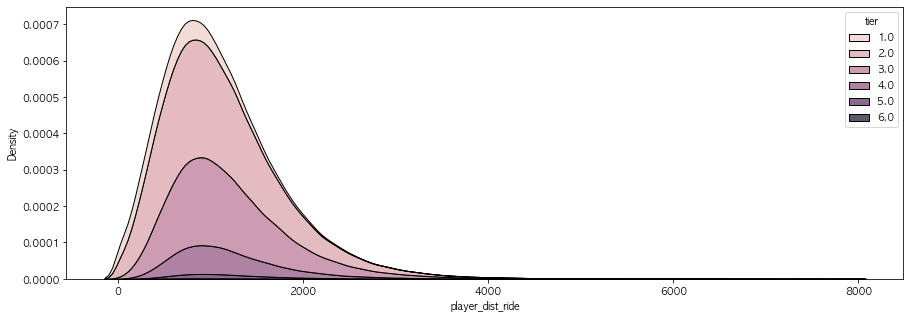

In [276]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dist_ride', hue='tier', multiple='stack')

In [259]:
solo_c['player_dist_ride']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.061314,1.000000
5.0,0.000000,0.000000,0.000000,0.061314,1.000000,1.000000
6.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


### kill_dist
* Tier가 높다고 kill_dist가 비례하여 커지는건 아니지만, 1~2/3~6은 구분되는 것처럼 보임

In [260]:
get_tier_median(solo, 'kill_dist')

,kill_dist
tier,
1.000,1379.069
2.000,2458.804
3.000,2956.776
4.000,3024.359
5.000,3031.629
6.000,2975.492


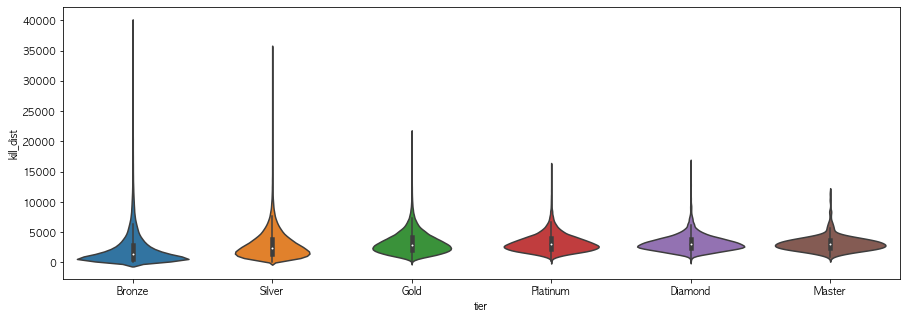

In [277]:
plt.figure(figsize=(15,5))
sns.violinplot(data=df, x='tier', y='kill_dist')
_ = plt.xticks(np.arange(6), ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master'])

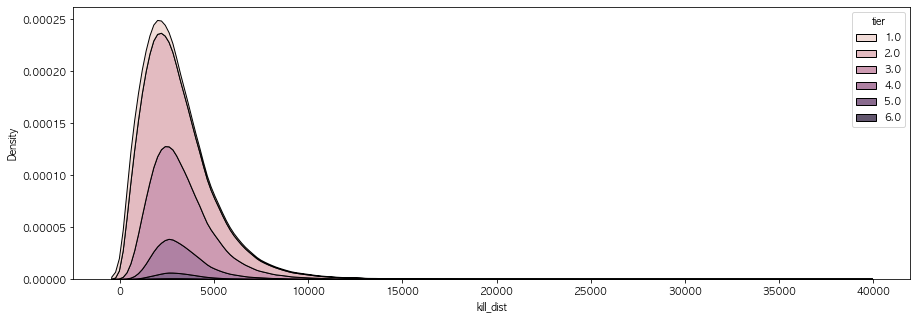

In [278]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='kill_dist', hue='tier', multiple='stack')

In [279]:
solo_c['kill_dist']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
6.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


### player_survive_time
* 확실히 높은 티어일수록 1500초 이상 살아있는 경우가 많음

In [280]:
get_tier_median(solo, 'player_survive_time')

,player_survive_time
tier,
1.000,575.700
2.000,719.385
3.000,759.026
4.000,745.021
5.000,736.954
6.000,731.549


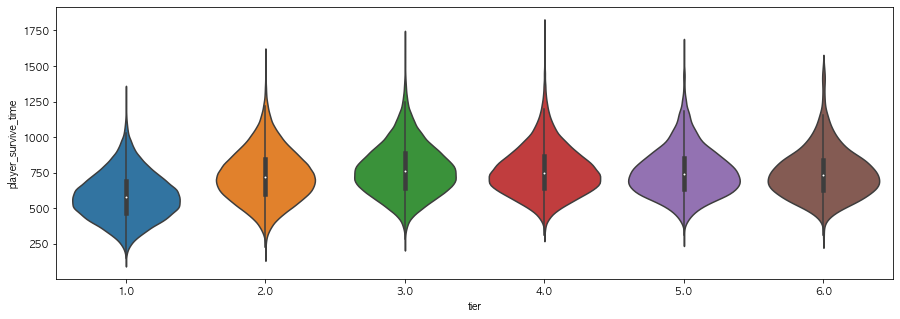

In [282]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_survive_time')

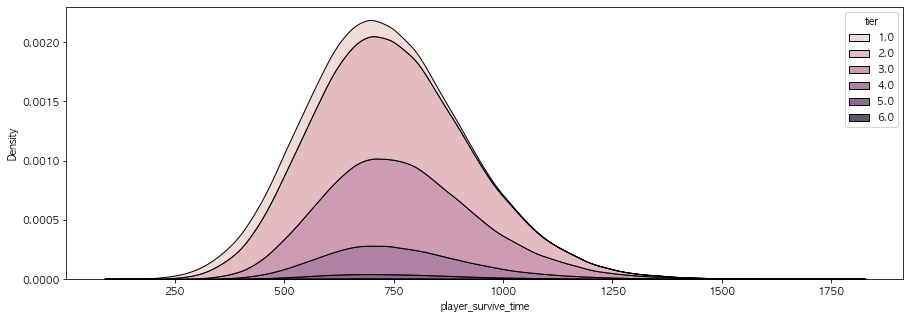

In [283]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_survive_time', hue='tier', multiple='stack')

In [284]:
solo_c['player_survive_time']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.127365
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000219
4.0,0.000000,0.000000,0.000000,1.000000,0.002566,0.020167
5.0,0.000000,0.000000,0.000000,0.002566,1.000000,0.127365
6.0,0.000000,0.127365,0.000219,0.020167,0.127365,1.000000


### team_placement
* Tier 1은 확실히 낮은 등수를 기록하는 경우가 많음

In [285]:
get_tier_median(solo, 'team_placement')

,team_placement
tier,
1.000,29.800
2.000,25.667
3.000,24.718
4.000,25.047
5.000,25.146
6.000,25.582


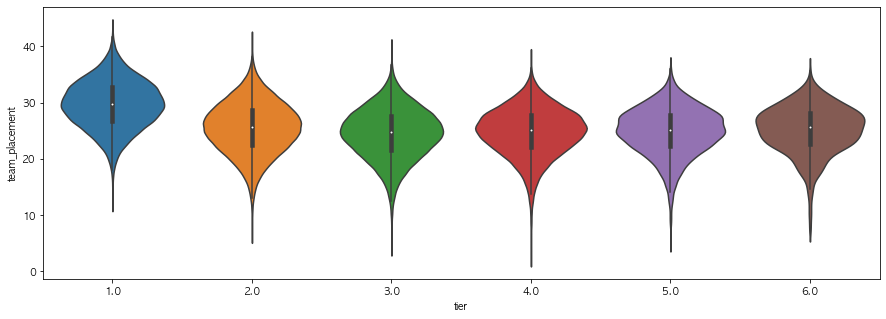

In [286]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='team_placement')

In [287]:
solo_c['team_placement']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.176605
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000240
4.0,0.000000,0.000000,0.000000,1.000000,0.027206,0.027206
5.0,0.000000,0.000000,0.000000,0.027206,1.000000,0.176605
6.0,0.000000,0.176605,0.000240,0.027206,0.176605,1.000000


### num_of_match

In [288]:
get_tier_median(solo, 'num_of_match')

,num_of_match
tier,
1.000,11
2.000,13
3.000,22
4.000,44
5.000,85
6.000,175


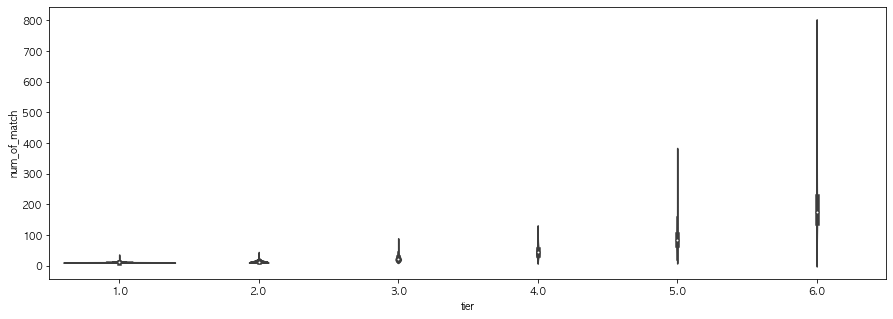

In [289]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='num_of_match')

In [290]:
solo_c['num_of_match']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.027498
6.0,0.000000,0.000000,0.000000,0.000000,0.027498,1.000000


## Duo

In [ ]:
duo = tier_diff[1]

In [175]:
duo_tier = get_tier_df(duo)

In [ ]:
duo.corr().style.background_gradient(cmap='Blues')

In [169]:
duo.groupby('tier').mean()

,player_kills,player_dmg,player_assists,player_dbno,kda,player_dist_walk,player_dist_ride,kill_dist,player_survive_time,team_placement,num_of_match
tier,,,,,,,,,,,
1.000,0.328,54.034,0.121,0.255,0.450,869.150,757.750,2291.038,585.483,29.700,10.995
2.000,0.740,107.030,0.200,0.503,0.954,1145.747,1092.852,2976.333,730.444,25.536,13.740
3.000,1.062,146.216,0.249,0.690,1.353,1216.736,1207.519,3283.141,772.982,24.514,23.314
4.000,1.191,161.499,0.261,0.767,1.521,1186.687,1216.130,3286.281,763.492,24.745,45.543
5.000,1.314,174.857,0.281,0.834,1.674,1163.218,1231.058,3237.264,756.397,24.882,88.560
6.000,1.389,182.751,0.293,0.875,1.786,1146.015,1214.897,3162.739,746.533,25.142,193.790


In [221]:
check_cols = duo.groupby('tier').mean().columns

duo_n, duo_k, duo_c = checking_tier_diff(duo, duo_tier, check_cols)

  0%|          | 0/11 [00:00<?, ?it/s]

In [224]:
duo_n

{'player_kills': [False, False, False, False, False, False],
 'player_dmg': [False, False, False, False, False, False],
 'player_assists': [False, False, False, False, False, False],
 'player_dbno': [False, False, False, False, False, False],
 'kda': [False, False, False, False, False, False],
 'player_dist_walk': [False, False, False, False, False, False],
 'player_dist_ride': [False, False, False, False, False, False],
 'kill_dist': [False, False, False, False, False, False],
 'player_survive_time': [False, False, False, False, False, False],
 'team_placement': [False, False, False, False, False, False],
 'num_of_match': [False, False, False, False, False, False]}

In [225]:
duo_k

{'player_kills': 0.0,
 'player_dmg': 0.0,
 'player_assists': 0.0,
 'player_dbno': 0.0,
 'kda': 0.0,
 'player_dist_walk': 0.0,
 'player_dist_ride': 0.0,
 'kill_dist': nan,
 'player_survive_time': 0.0,
 'team_placement': 0.0,
 'num_of_match': 0.0}

### player_kills
* Tier와 평균 kill 횟수는 비례함

In [235]:
get_tier_median(duo, 'player_kills')

,player_kills
tier,
1.000,0.300
2.000,0.667
3.000,0.923
4.000,1.021
5.000,1.142
6.000,1.250


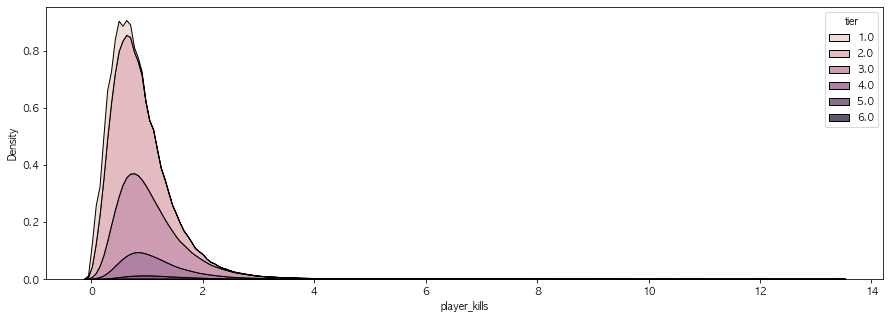

In [265]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='player_kills', hue='tier', multiple='stack')

In [226]:
duo_c['player_kills']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.008726
6.0,0.000000,0.000000,0.000000,0.000000,0.008726,1.000000


### player_dmg

In [236]:
get_tier_median(duo, 'player_dmg')

,player_dmg
tier,
1.000,52.833
2.000,100.700
3.000,131.538
4.000,142.800
5.000,156.502
6.000,165.968


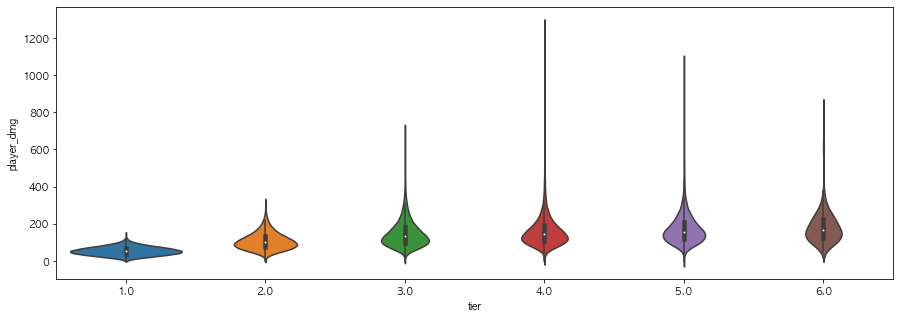

In [266]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_dmg')

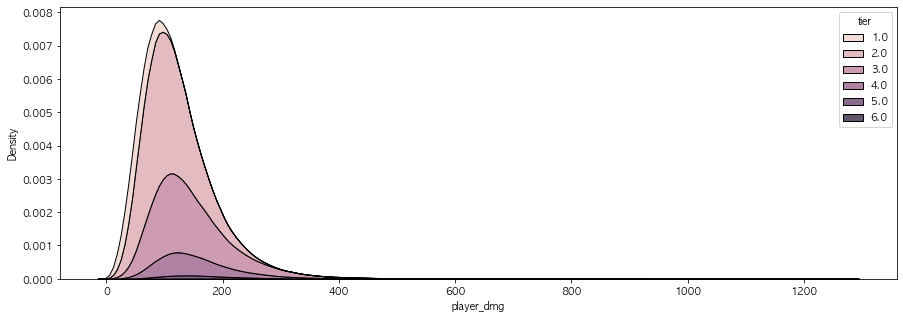

In [267]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dmg', hue='tier', multiple='stack')

In [239]:
duo_c['player_dmg']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.017837
6.0,0.000000,0.000000,0.000000,0.000000,0.017837,1.000000


### player_assists
* Tier와 평균 assits 횟수는 비례함 

In [240]:
get_tier_median(duo, 'player_assists')

,player_assists
tier,
1.000,0.100
2.000,0.176
3.000,0.217
4.000,0.233
5.000,0.255
6.000,0.264


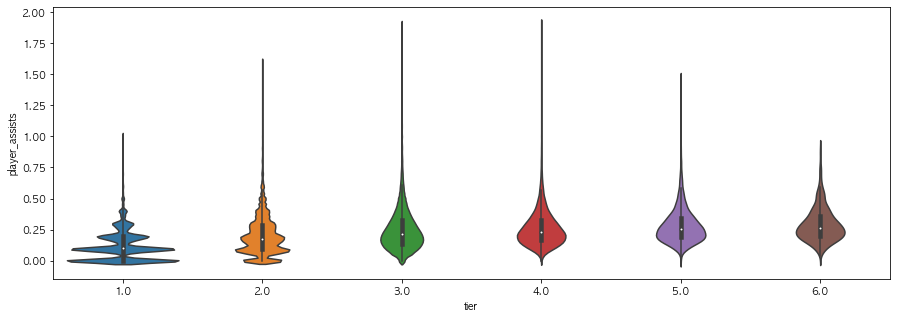

In [268]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_assists')

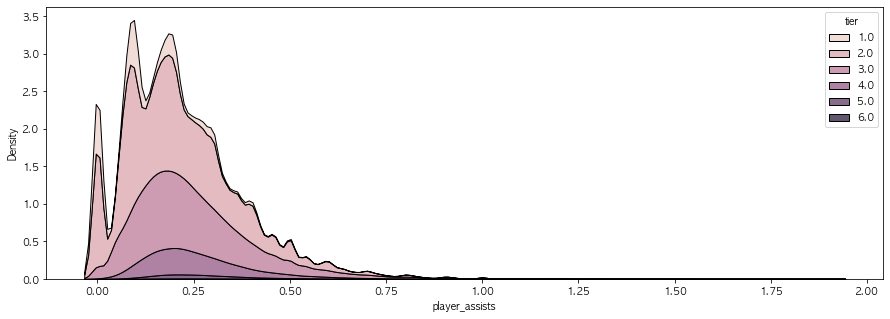

In [269]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_assists', hue='tier', multiple='stack')

In [243]:
duo_c['player_assists']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.036097
6.0,0.000000,0.000000,0.000000,0.000000,0.036097,1.000000


### player_dbno
* Tier와 평균 dbno 횟수는 비례함 

In [244]:
get_tier_median(duo, 'player_dbno')

,player_dbno
tier,
1.000,0.231
2.000,0.462
3.000,0.615
4.000,0.674
5.000,0.745
6.000,0.815


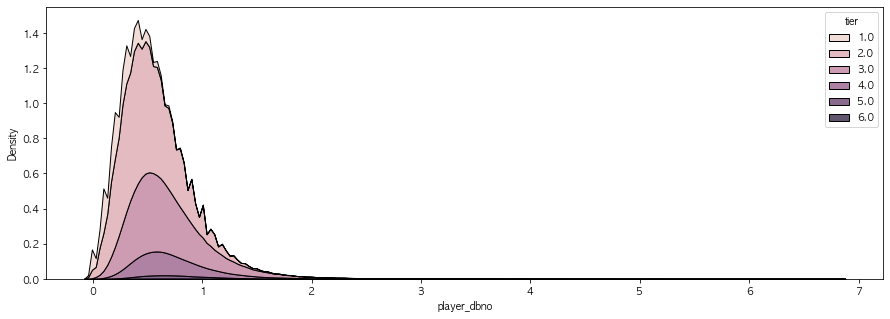

In [270]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dbno', hue='tier', multiple='stack')

In [246]:
duo_c['player_dbno']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.007047
6.0,0.000000,0.000000,0.000000,0.000000,0.007047,1.000000


### kda
* Tier와 평균 kda는 비례함

In [248]:
get_tier_median(duo, 'kda')

,kda
tier,
1.000,0.417
2.000,0.875
3.000,1.172
4.000,1.282
5.000,1.427
6.000,1.555


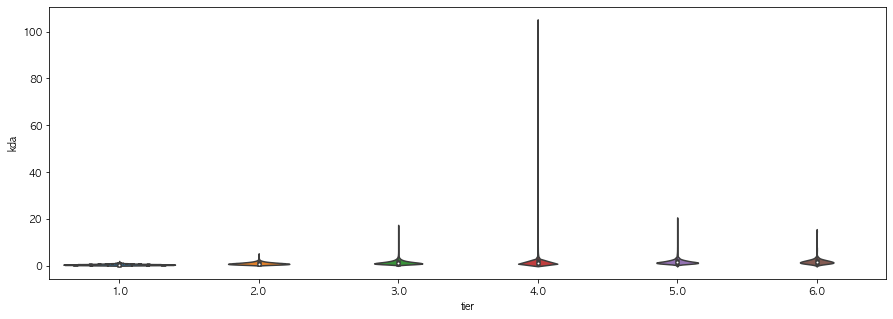

In [271]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='kda')

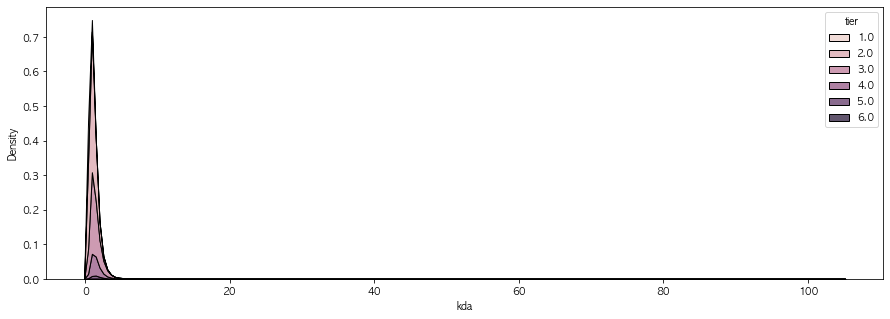

In [272]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='kda', hue='tier', multiple='stack')

In [251]:
duo_c['kda']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.013054
6.0,0.000000,0.000000,0.000000,0.000000,0.013054,1.000000


### player_dist_walk
* Tier 1~3 에서 평균 거리가 증가
* Tier 3~6 에서는 거리가 감소
* Tier 2와 5는 평균의 차이가 없음

In [252]:
get_tier_median(duo, 'player_dist_walk')

,player_dist_walk
tier,
1.000,838.463
2.000,1112.323
3.000,1180.451
4.000,1148.594
5.000,1122.241
6.000,1104.615


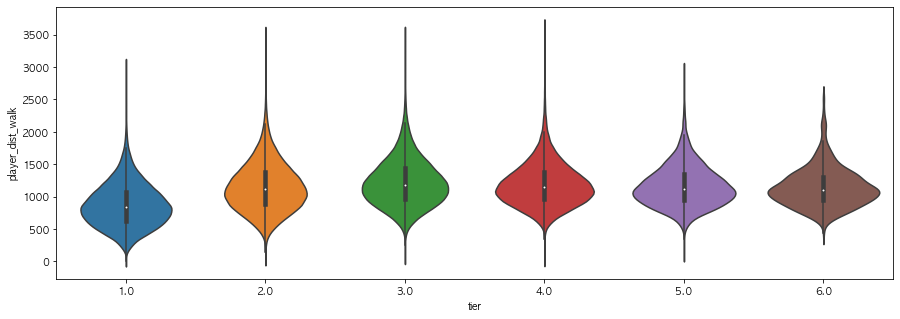

In [273]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_dist_walk')

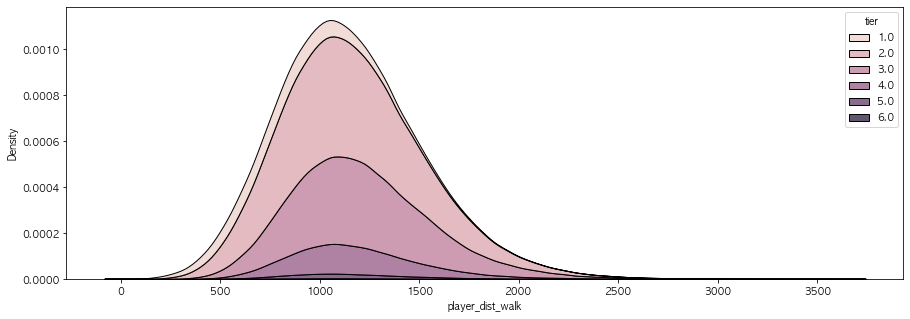

In [274]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dist_walk', hue='tier', multiple='stack')

In [255]:
duo_c['player_dist_walk']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000001,0.835714
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000003
4.0,0.000000,0.000000,0.000000,1.000000,0.000002,0.007367
5.0,0.000000,0.000001,0.000000,0.000002,1.000000,0.354439
6.0,0.000000,0.835714,0.000003,0.007367,0.354439,1.000000


### player_dist_ride
* Tier 1에서는 확실히 탈것을 활용한 이동 거리가 짧음
* Tier 2부터는 그룹간의 차이가 있긴하는하지만, tier와 탈것을 활용한 이동 거리가 정비례 하지는 않음

In [256]:
get_tier_median(duo, 'player_dist_ride')

,player_dist_ride
tier,
1.000,657.042
2.000,977.059
3.000,1087.587
4.000,1096.282
5.000,1104.539
6.000,1074.015


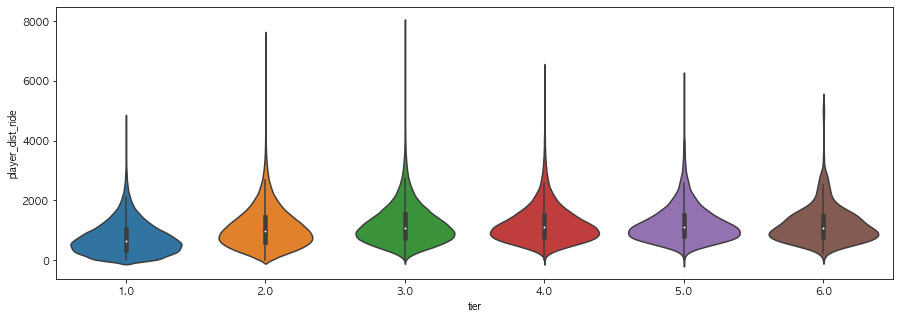

In [275]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_dist_ride')

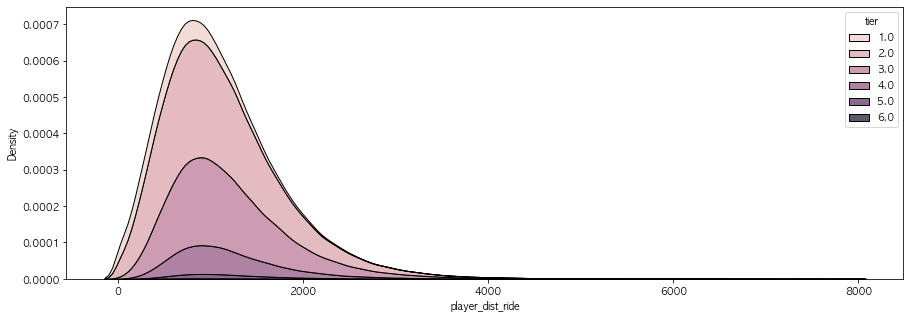

In [276]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dist_ride', hue='tier', multiple='stack')

In [259]:
duo_c['player_dist_ride']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.061314,1.000000
5.0,0.000000,0.000000,0.000000,0.061314,1.000000,1.000000
6.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


### kill_dist
* Tier가 높다고 kill_dist가 비례하여 커지는건 아니지만, 1~2/3~6은 구분되는 것처럼 보임

In [260]:
get_tier_median(duo, 'kill_dist')

,kill_dist
tier,
1.000,1379.069
2.000,2458.804
3.000,2956.776
4.000,3024.359
5.000,3031.629
6.000,2975.492


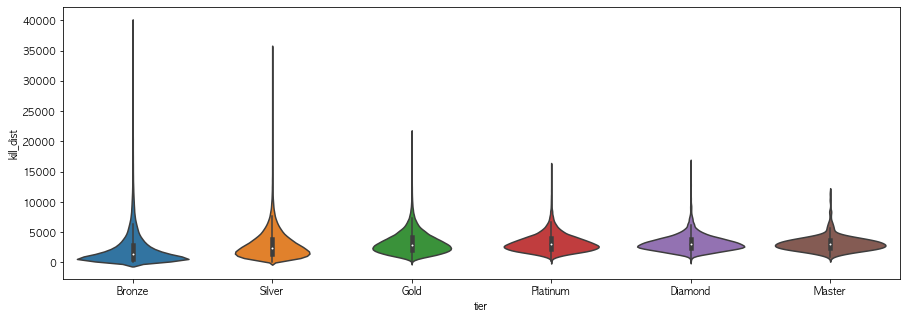

In [277]:
plt.figure(figsize=(15,5))
sns.violinplot(data=df, x='tier', y='kill_dist')
_ = plt.xticks(np.arange(6), ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master'])

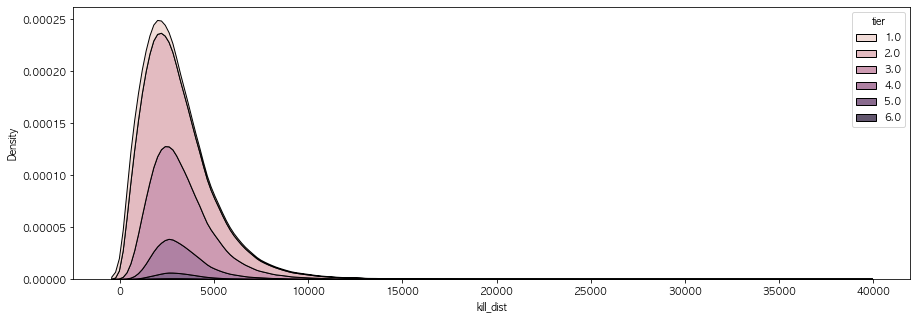

In [278]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='kill_dist', hue='tier', multiple='stack')

In [279]:
duo_c['kill_dist']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
6.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


### player_survive_time
* 확실히 높은 티어일수록 1500초 이상 살아있는 경우가 많음

In [280]:
get_tier_median(duo, 'player_survive_time')

,player_survive_time
tier,
1.000,575.700
2.000,719.385
3.000,759.026
4.000,745.021
5.000,736.954
6.000,731.549


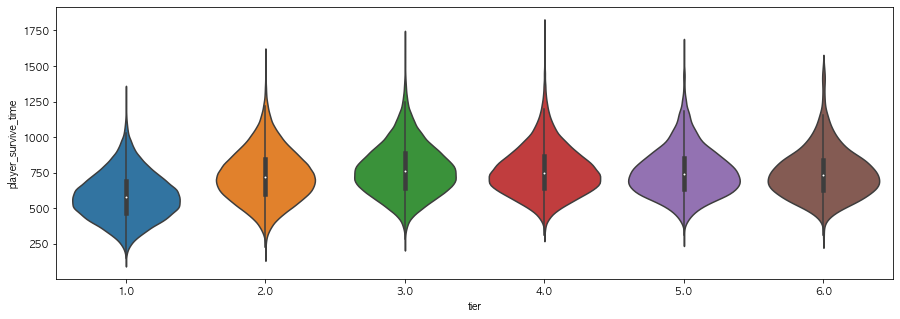

In [282]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_survive_time')

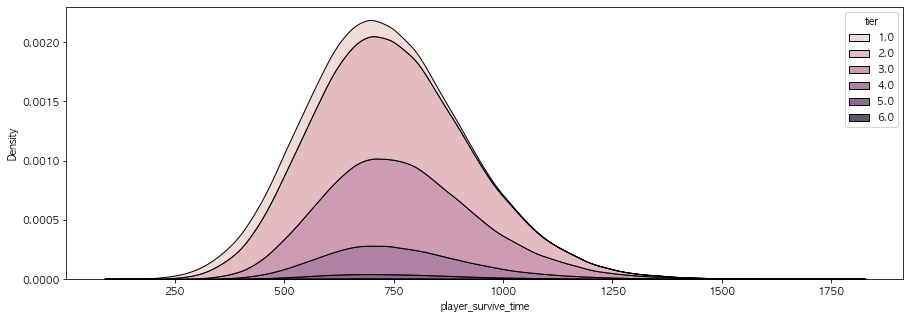

In [283]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_survive_time', hue='tier', multiple='stack')

In [284]:
duo_c['player_survive_time']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.127365
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000219
4.0,0.000000,0.000000,0.000000,1.000000,0.002566,0.020167
5.0,0.000000,0.000000,0.000000,0.002566,1.000000,0.127365
6.0,0.000000,0.127365,0.000219,0.020167,0.127365,1.000000


### team_placement
* Tier 1은 확실히 낮은 등수를 기록하는 경우가 많음

In [285]:
get_tier_median(duo, 'team_placement')

,team_placement
tier,
1.000,29.800
2.000,25.667
3.000,24.718
4.000,25.047
5.000,25.146
6.000,25.582


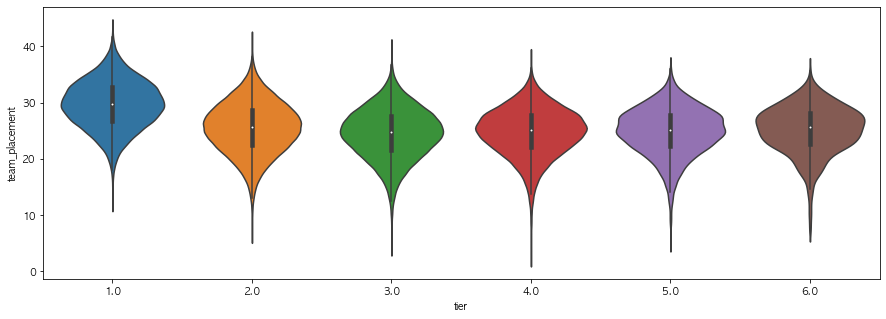

In [286]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='team_placement')

In [287]:
duo_c['team_placement']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.176605
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000240
4.0,0.000000,0.000000,0.000000,1.000000,0.027206,0.027206
5.0,0.000000,0.000000,0.000000,0.027206,1.000000,0.176605
6.0,0.000000,0.176605,0.000240,0.027206,0.176605,1.000000


### num_of_match

In [288]:
get_tier_median(duo, 'num_of_match')

,num_of_match
tier,
1.000,11
2.000,13
3.000,22
4.000,44
5.000,85
6.000,175


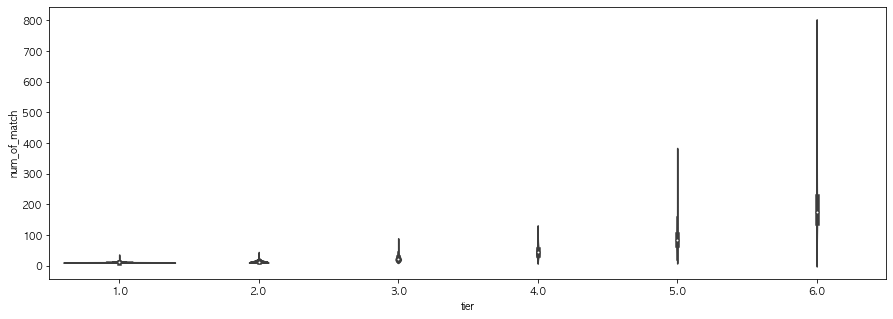

In [289]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='num_of_match')

In [290]:
duo_c['num_of_match']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.027498
6.0,0.000000,0.000000,0.000000,0.000000,0.027498,1.000000


## Squad

In [ ]:
squad = tier_diff[1]

In [175]:
squad_tier = get_tier_df(squad)

In [ ]:
squad.corr().style.background_gradient(cmap='Blues')

In [169]:
squad.groupby('tier').mean()

,player_kills,player_dmg,player_assists,player_dbno,kda,player_dist_walk,player_dist_ride,kill_dist,player_survive_time,team_placement,num_of_match
tier,,,,,,,,,,,
1.000,0.328,54.034,0.121,0.255,0.450,869.150,757.750,2291.038,585.483,29.700,10.995
2.000,0.740,107.030,0.200,0.503,0.954,1145.747,1092.852,2976.333,730.444,25.536,13.740
3.000,1.062,146.216,0.249,0.690,1.353,1216.736,1207.519,3283.141,772.982,24.514,23.314
4.000,1.191,161.499,0.261,0.767,1.521,1186.687,1216.130,3286.281,763.492,24.745,45.543
5.000,1.314,174.857,0.281,0.834,1.674,1163.218,1231.058,3237.264,756.397,24.882,88.560
6.000,1.389,182.751,0.293,0.875,1.786,1146.015,1214.897,3162.739,746.533,25.142,193.790


In [221]:
check_cols = squad.groupby('tier').mean().columns

squad_n, squad_k, squad_c = checking_tier_diff(squad, squad_tier, check_cols)

  0%|          | 0/11 [00:00<?, ?it/s]

In [224]:
squad_n

{'player_kills': [False, False, False, False, False, False],
 'player_dmg': [False, False, False, False, False, False],
 'player_assists': [False, False, False, False, False, False],
 'player_dbno': [False, False, False, False, False, False],
 'kda': [False, False, False, False, False, False],
 'player_dist_walk': [False, False, False, False, False, False],
 'player_dist_ride': [False, False, False, False, False, False],
 'kill_dist': [False, False, False, False, False, False],
 'player_survive_time': [False, False, False, False, False, False],
 'team_placement': [False, False, False, False, False, False],
 'num_of_match': [False, False, False, False, False, False]}

In [225]:
squad_k

{'player_kills': 0.0,
 'player_dmg': 0.0,
 'player_assists': 0.0,
 'player_dbno': 0.0,
 'kda': 0.0,
 'player_dist_walk': 0.0,
 'player_dist_ride': 0.0,
 'kill_dist': nan,
 'player_survive_time': 0.0,
 'team_placement': 0.0,
 'num_of_match': 0.0}

### player_kills
* Tier와 평균 kill 횟수는 비례함

In [235]:
get_tier_median(squad, 'player_kills')

,player_kills
tier,
1.000,0.300
2.000,0.667
3.000,0.923
4.000,1.021
5.000,1.142
6.000,1.250


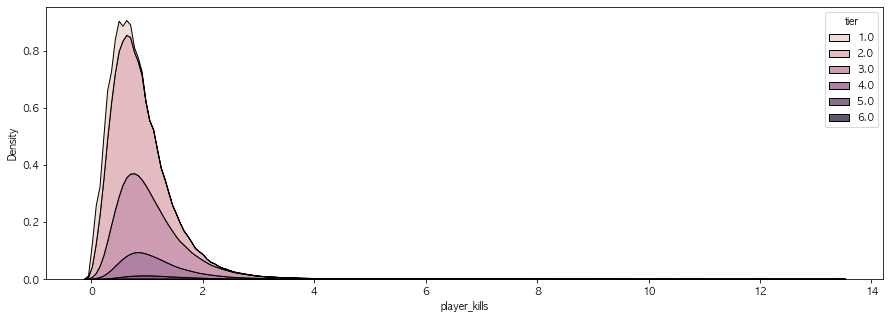

In [265]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='player_kills', hue='tier', multiple='stack')

In [226]:
squad_c['player_kills']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.008726
6.0,0.000000,0.000000,0.000000,0.000000,0.008726,1.000000


### player_dmg

In [236]:
get_tier_median(squad, 'player_dmg')

,player_dmg
tier,
1.000,52.833
2.000,100.700
3.000,131.538
4.000,142.800
5.000,156.502
6.000,165.968


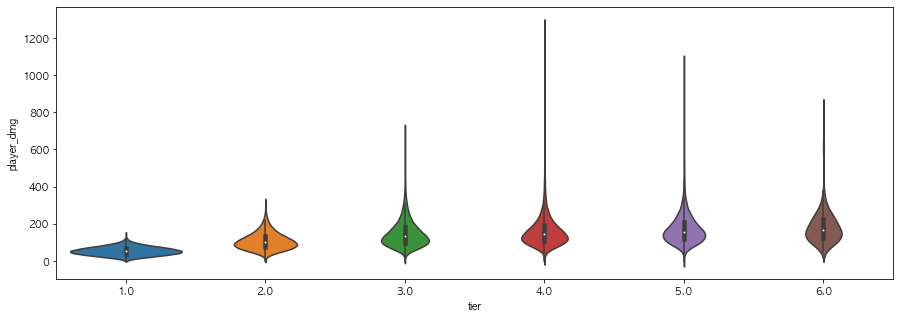

In [266]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_dmg')

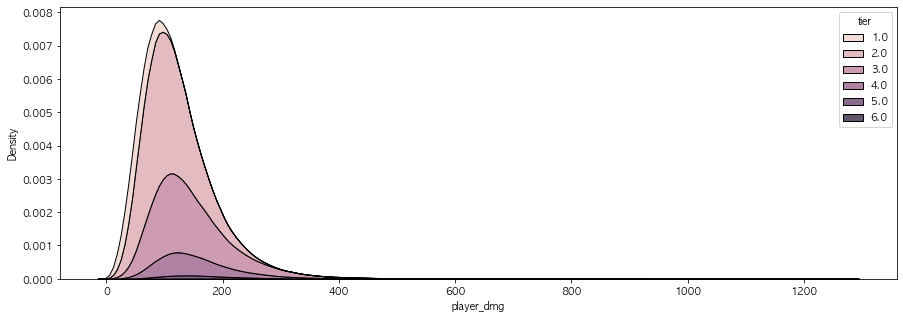

In [267]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dmg', hue='tier', multiple='stack')

In [239]:
squad_c['player_dmg']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.017837
6.0,0.000000,0.000000,0.000000,0.000000,0.017837,1.000000


### player_assists
* Tier와 평균 assits 횟수는 비례함 

In [240]:
get_tier_median(squad, 'player_assists')

,player_assists
tier,
1.000,0.100
2.000,0.176
3.000,0.217
4.000,0.233
5.000,0.255
6.000,0.264


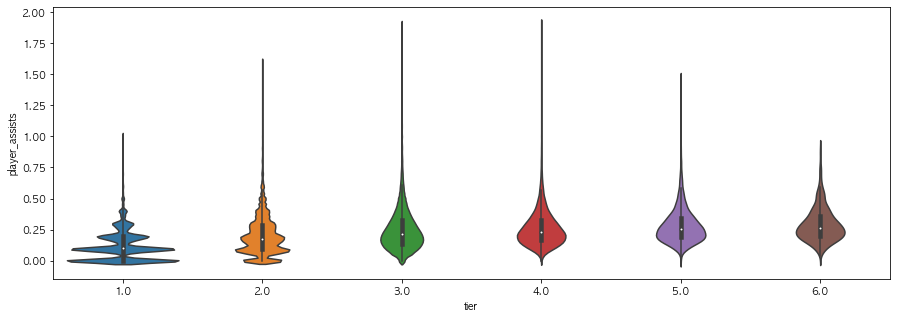

In [268]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_assists')

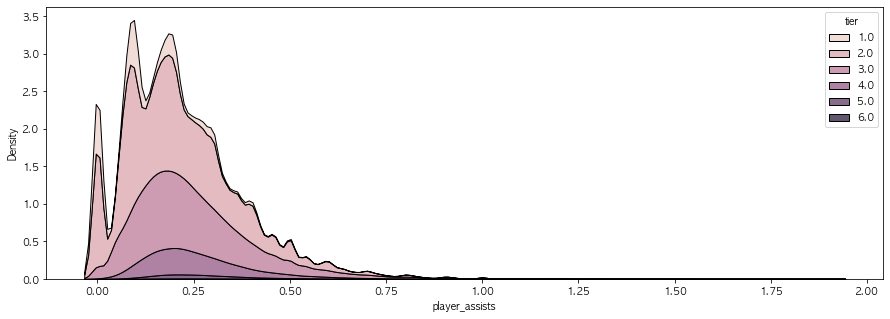

In [269]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_assists', hue='tier', multiple='stack')

In [243]:
squad_c['player_assists']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.036097
6.0,0.000000,0.000000,0.000000,0.000000,0.036097,1.000000


### player_dbno
* Tier와 평균 dbno 횟수는 비례함 

In [244]:
get_tier_median(squad, 'player_dbno')

,player_dbno
tier,
1.000,0.231
2.000,0.462
3.000,0.615
4.000,0.674
5.000,0.745
6.000,0.815


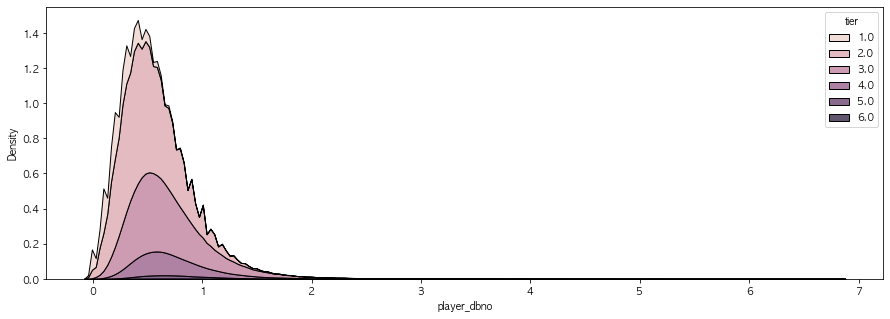

In [270]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dbno', hue='tier', multiple='stack')

In [246]:
squad_c['player_dbno']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.007047
6.0,0.000000,0.000000,0.000000,0.000000,0.007047,1.000000


### kda
* Tier와 평균 kda는 비례함

In [248]:
get_tier_median(squad, 'kda')

,kda
tier,
1.000,0.417
2.000,0.875
3.000,1.172
4.000,1.282
5.000,1.427
6.000,1.555


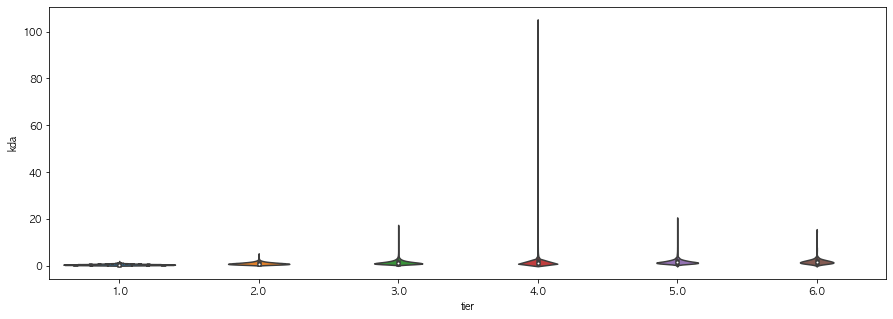

In [271]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='kda')

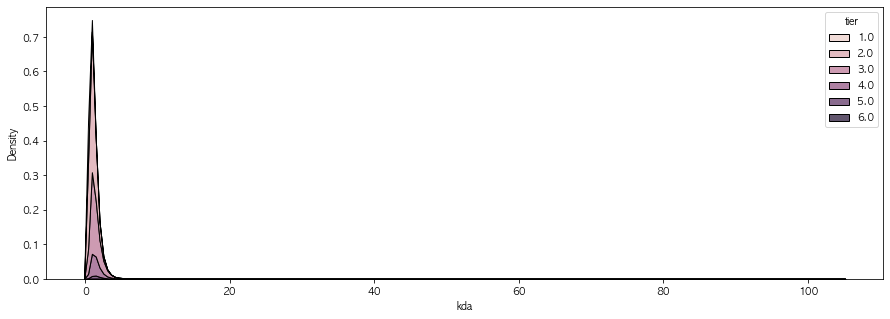

In [272]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='kda', hue='tier', multiple='stack')

In [251]:
squad_c['kda']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.013054
6.0,0.000000,0.000000,0.000000,0.000000,0.013054,1.000000


### player_dist_walk
* Tier 1~3 에서 평균 거리가 증가
* Tier 3~6 에서는 거리가 감소
* Tier 2와 5는 평균의 차이가 없음

In [252]:
get_tier_median(squad, 'player_dist_walk')

,player_dist_walk
tier,
1.000,838.463
2.000,1112.323
3.000,1180.451
4.000,1148.594
5.000,1122.241
6.000,1104.615


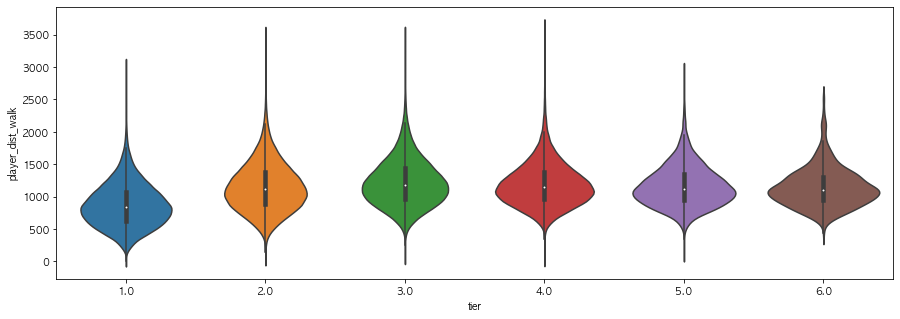

In [273]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_dist_walk')

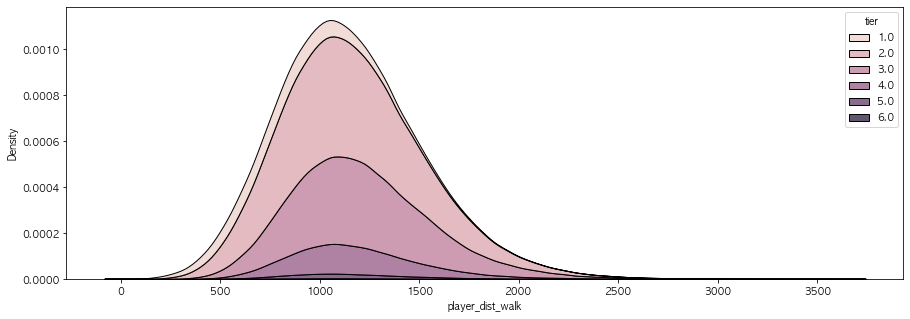

In [274]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dist_walk', hue='tier', multiple='stack')

In [255]:
squad_c['player_dist_walk']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000001,0.835714
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000003
4.0,0.000000,0.000000,0.000000,1.000000,0.000002,0.007367
5.0,0.000000,0.000001,0.000000,0.000002,1.000000,0.354439
6.0,0.000000,0.835714,0.000003,0.007367,0.354439,1.000000


### player_dist_ride
* Tier 1에서는 확실히 탈것을 활용한 이동 거리가 짧음
* Tier 2부터는 그룹간의 차이가 있긴하는하지만, tier와 탈것을 활용한 이동 거리가 정비례 하지는 않음

In [256]:
get_tier_median(squad, 'player_dist_ride')

,player_dist_ride
tier,
1.000,657.042
2.000,977.059
3.000,1087.587
4.000,1096.282
5.000,1104.539
6.000,1074.015


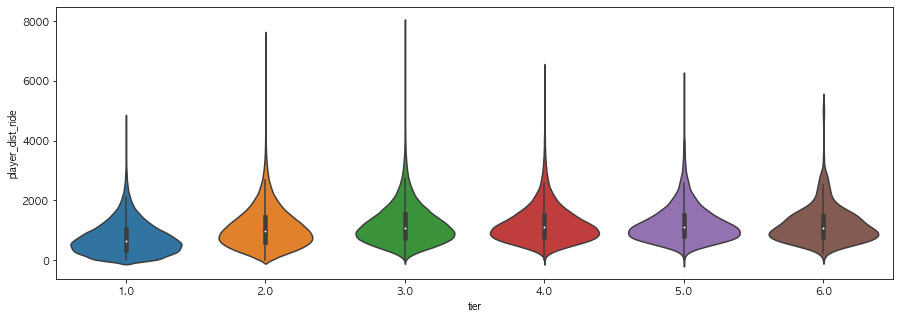

In [275]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_dist_ride')

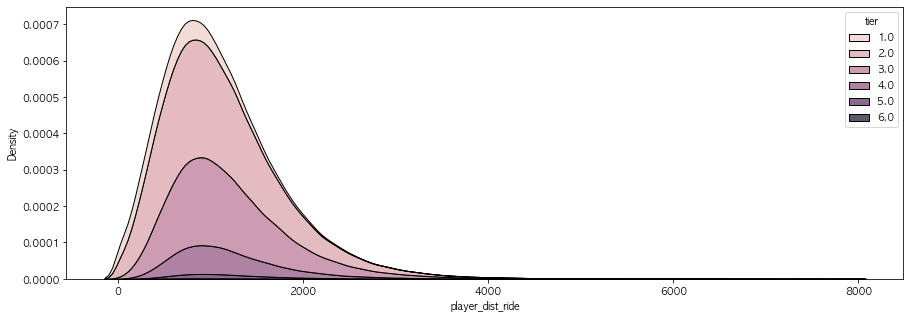

In [276]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_dist_ride', hue='tier', multiple='stack')

In [259]:
squad_c['player_dist_ride']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.061314,1.000000
5.0,0.000000,0.000000,0.000000,0.061314,1.000000,1.000000
6.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


### kill_dist
* Tier가 높다고 kill_dist가 비례하여 커지는건 아니지만, 1~2/3~6은 구분되는 것처럼 보임

In [260]:
get_tier_median(squad, 'kill_dist')

,kill_dist
tier,
1.000,1379.069
2.000,2458.804
3.000,2956.776
4.000,3024.359
5.000,3031.629
6.000,2975.492


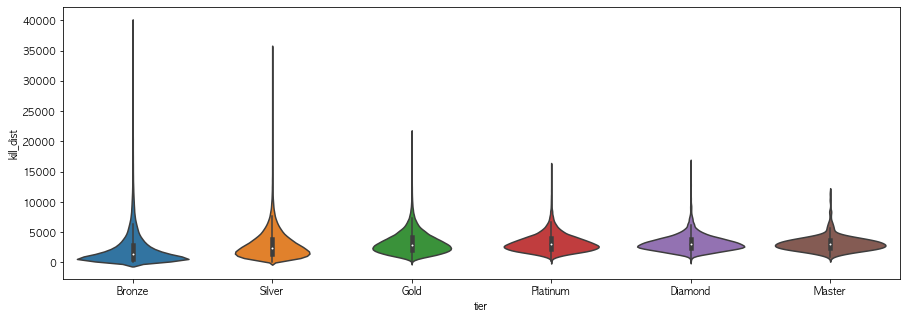

In [277]:
plt.figure(figsize=(15,5))
sns.violinplot(data=df, x='tier', y='kill_dist')
_ = plt.xticks(np.arange(6), ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master'])

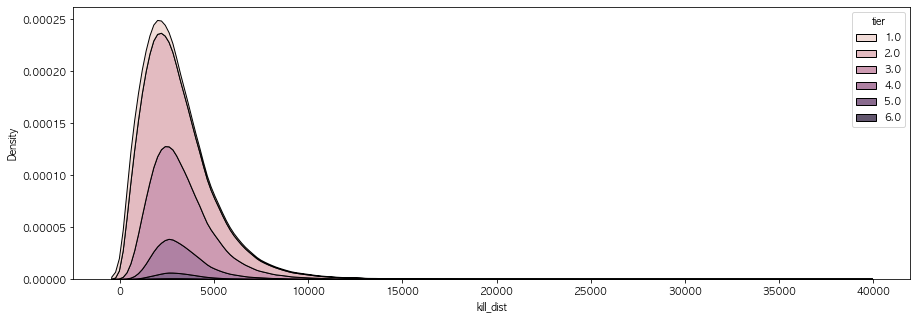

In [278]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='kill_dist', hue='tier', multiple='stack')

In [279]:
squad_c['kill_dist']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
6.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


### player_survive_time
* 확실히 높은 티어일수록 1500초 이상 살아있는 경우가 많음

In [280]:
get_tier_median(squad, 'player_survive_time')

,player_survive_time
tier,
1.000,575.700
2.000,719.385
3.000,759.026
4.000,745.021
5.000,736.954
6.000,731.549


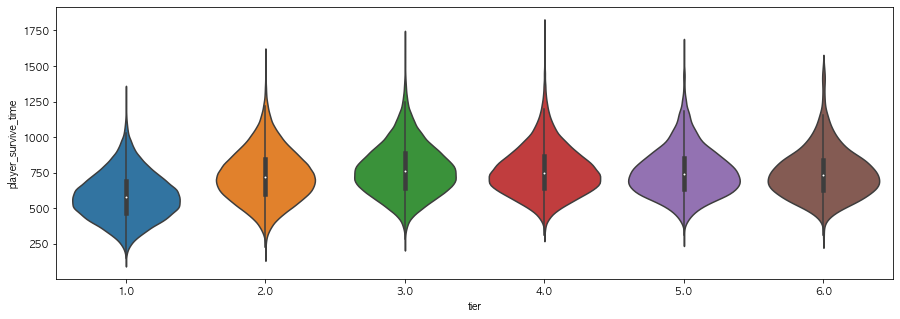

In [282]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='player_survive_time')

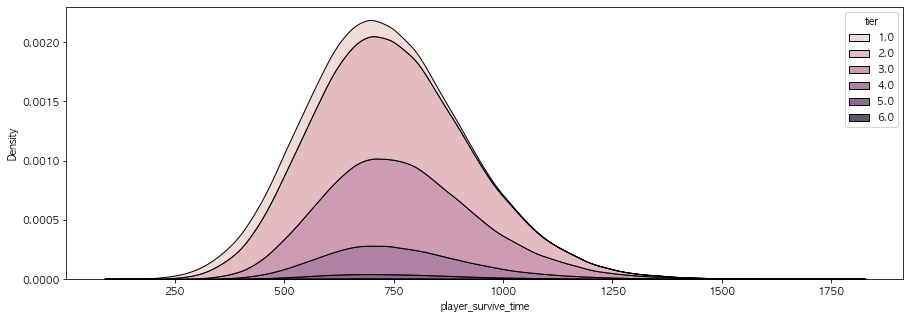

In [283]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=df, x='player_survive_time', hue='tier', multiple='stack')

In [284]:
squad_c['player_survive_time']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.127365
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000219
4.0,0.000000,0.000000,0.000000,1.000000,0.002566,0.020167
5.0,0.000000,0.000000,0.000000,0.002566,1.000000,0.127365
6.0,0.000000,0.127365,0.000219,0.020167,0.127365,1.000000


### team_placement
* Tier 1은 확실히 낮은 등수를 기록하는 경우가 많음

In [285]:
get_tier_median(squad, 'team_placement')

,team_placement
tier,
1.000,29.800
2.000,25.667
3.000,24.718
4.000,25.047
5.000,25.146
6.000,25.582


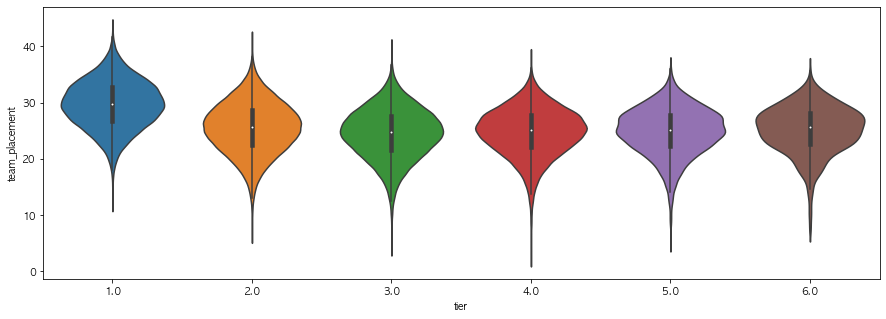

In [286]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='team_placement')

In [287]:
squad_c['team_placement']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.176605
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000240
4.0,0.000000,0.000000,0.000000,1.000000,0.027206,0.027206
5.0,0.000000,0.000000,0.000000,0.027206,1.000000,0.176605
6.0,0.000000,0.176605,0.000240,0.027206,0.176605,1.000000


### num_of_match

In [288]:
get_tier_median(squad, 'num_of_match')

,num_of_match
tier,
1.000,11
2.000,13
3.000,22
4.000,44
5.000,85
6.000,175


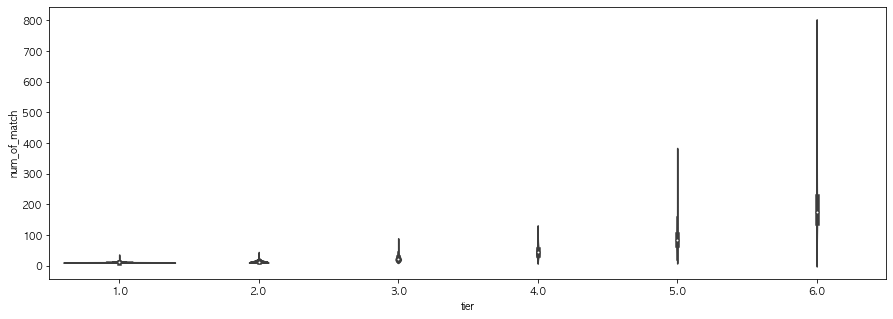

In [289]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=df, x='tier', y='num_of_match')

In [290]:
squad_c['num_of_match']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.027498
6.0,0.000000,0.000000,0.000000,0.000000,0.027498,1.000000
